In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import string
import re

from wordcloud import WordCloud
from nltk import bigrams
from collections import Counter
from nltk.corpus import stopwords

In [2]:
#cloning git
!git clone https://github.com/dorianb04/airline-ucg

Cloning into 'airline-ucg'...
remote: Enumerating objects: 103, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 103 (delta 3), reused 1 (delta 1), pack-reused 90 (from 3)
Receiving objects: 100% (103/103), 52.97 MiB | 18.49 MiB/s, done.
Resolving deltas: 100% (12/12), done.
Updating files: 100% (44/44), done.


In [3]:
companies = ['air-france', 'asiana-airlines', 'british-airways', 'iberia', 'japan-airlines-jal', 'lufthansa',
             'or520-emirates', 'or1030-korean-air', 'qatar-airways', 'ryanair' ,'singapore_airlines',
             'swiss-international-air-lines-swiss','turkish-airlines']

In [4]:
dataframes = []
for company in companies:
    df = pd.read_csv(f'airline-ucg/cleaning/{company}_reviews_cleaned.csv')  # Utiliser la variable company
    df['company'] = company  # Ajouter une colonne pour identifier la compagnie
    dataframes.append(df)

#concatenate everything in one dataframe
data = pd.concat(dataframes, ignore_index=True)

In [5]:
max(data['rating'])

5.0

In [6]:
min(data['rating'])

1.0

In [7]:
#define the value which separates statisfied and not satisfied customers
lim_rating = 2.5

lim_rating

2.5

In [8]:
#we create a column to categorize satisfied / not satisfied customers
data['satisfaction'] = data['rating'].apply(lambda x: 'Satisfied' if x > lim_rating else 'Not Satisfied')

In [9]:
data.shape

(59574, 18)

In [10]:
data.head()

title  departure destination  \
0                      Never travel  with Air France  Vancouver   New Delhi   
1                                   Terrible service    Chicago       Paris   
2                                          Traumatic     London     Algiers   
3  Air France,  the airline that keeps loosing lu...     London       Paris   
4                       ^^^^ Take Me  Home AF   ^^^^  Vancouver  Manchester   

   type_of_route                                        review_text  \
0  International  Worst Airline.stopped for door repair about 4 ...   
1  International  I boarded Air France on the 19th of December 2...   
2  International  A truly traumatic experience! So much that I g...   
3         Europe  Air France is quickly becoming the airline for...   
4  International  We had  surprisingly smooth  flight  with Air ...   

  travel_date review_date  rating  legroom_rating  seat_comfort_rating  \
0     2024-12  2024-12-21     1.0        1.000000             2.000000   
1     2024-12  2024-12-20     1.0        3.256587             3.118512   
2     2024-08  2024-12-19     2.0        1.000000             1.000000   
3     2024-12  2024-12-19     3.0        3.000000             3.000000   
4     2024-12  2024-12-19     4.0        4.000000             3.118512   

   entertainment_rating  customer_service_rating  value_rating  \
0              1.000000                  1.00000      1.000000   
1              3.121919                  3.08162      2.932936   
2              1.000000                  2.00000      1.000000   
3              3.000000                  4.00000      3.000000   
4              4.000000                  4.00000      4.000000   

   cleanliness_rating  check_in_rating  food_rating     company   satisfaction  
0            2.000000         1.000000     1.000000  air-france  Not Satisfied  
1            3.497865         3.217346     3.081991  air-france  Not Satisfied  
2            1.000000         1.000000     1.000000  air-france  Not Satisfied  
3            4.000000         3.000000     4.000000  air-france      Satisfied  
4            4.000000         4.000000     3.000000  air-france      Satisfied

In [11]:
proportions_total = data['satisfaction'].value_counts(normalize=True)

proportions_total

satisfaction
Not Satisfied    0.558146
Satisfied        0.441854
Name: proportion, dtype: float64

In [12]:
#we compute the proportion of satisfied / not satisfied
proportions = data.groupby(['company', 'satisfaction']).size().unstack(fill_value=0)
proportions = proportions.div(proportions.sum(axis=1), axis=0)

proportions_sorted = proportions.sort_values(by='Satisfied', ascending=False)

proportions_sorted

satisfaction                         Not Satisfied  Satisfied
company                                                      
or1030-korean-air                         0.109125   0.890875
japan-airlines-jal                        0.121301   0.878699
asiana-airlines                           0.176950   0.823050
singapore_airlines                        0.214835   0.785165
swiss-international-air-lines-swiss       0.403571   0.596429
air-france                                0.508295   0.491705
or520-emirates                            0.540041   0.459959
iberia                                    0.652642   0.347358
qatar-airways                             0.733736   0.266264
british-airways                           0.789094   0.210906
lufthansa                                 0.843592   0.156408
turkish-airlines                          0.864588   0.135412
ryanair                                   0.880681   0.119319

<Figure size 1200x800 with 0 Axes>

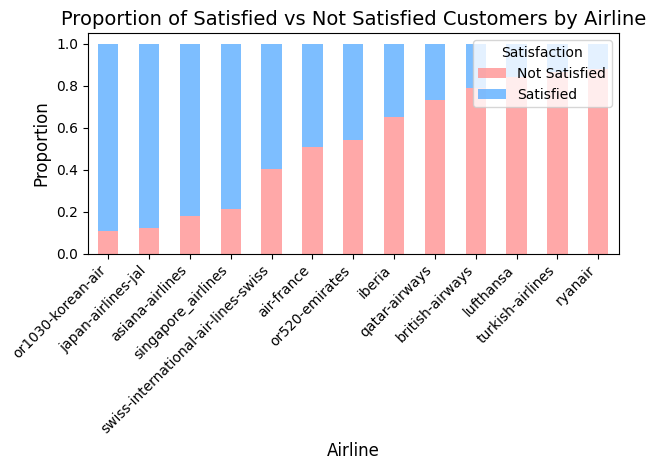

In [13]:
plt.figure(figsize=(12, 8))
proportions_sorted.plot(kind='bar', stacked=True, color=['#FF9999', '#66B3FF'], alpha=0.85)

plt.title('Proportion of Satisfied vs Not Satisfied Customers by Airline', fontsize=14)
plt.ylabel('Proportion', fontsize=12)
plt.xlabel('Airline', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Satisfaction', loc='upper right')
plt.tight_layout()

plt.show()

In [14]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [15]:
# Preprocess: delete stopwords, lower, remove punctuation
def preprocess_text(text):
    text = ''.join(char for char in text if char not in string.punctuation)
    text = text.lower()
    return ' '.join(word for word in text.split() if word not in stop_words)

In [16]:
def generate_bigram_wordcloud(data, company_name, min_bigrams):
    # Filter data for the company
    company_data = data[data['company'] == company_name]

    company_data['cleaned_review_text'] = company_data['review_text'].dropna().apply(preprocess_text)

    # Extract bigrams
    all_text = ' '.join(company_data['cleaned_review_text'].dropna())
    bigram_list = list(bigrams(all_text.split()))
    bigram_counts = Counter(bigram_list)

    # Filter bigrams appearing more than `min_bigrams` times
    frequent_bigrams = {f"{w1} {w2}": count for (w1, w2), count in bigram_counts.items() if count > min_bigrams}

    # Calculate average ratings for each bigram and count occurrences
    def bigram_rating(bigram):
        pattern = r'\b{}\b \b{}\b'.format(bigram[0], bigram[1])
        reviews_containing_bigram = company_data[company_data['cleaned_review_text'].str.contains(pattern, na=False, regex=True)]
        return reviews_containing_bigram['rating'].mean(), len(reviews_containing_bigram)

    bigram_ratings = {bigram: bigram_rating(tuple(bigram.split())) for bigram in frequent_bigrams.keys()}

    # Define min/max rating
    min_rating = 1
    max_rating = 5

    # Define color scale logic
    def color_func(word, font_size, position, orientation, random_state=None, **kwargs):
        rating, _ = bigram_ratings[word]

        # color according to the rating
        if rating <= 1.5:  # dark red
            color = sns.color_palette("Reds", 7)[6]
        elif rating <= 2.2:  # red
            color = sns.color_palette("Reds", 7)[4]
        elif rating <= 2.8:  # grey
            color = sns.color_palette("Greys", 7)[4]
        elif rating <= 3.5:  # green
            color = sns.color_palette("Greens", 7)[2]
        else:  # dark green
            color = sns.color_palette("Greens", 7)[6]

        # RGB
        return tuple([int(c * 255) for c in color[:3]])

    # Generate word cloud
    wc = WordCloud(width=800, height=400, background_color='white', color_func=color_func).generate_from_frequencies(frequent_bigrams)

    # Display word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Bigram WordCloud for {company_name}", fontsize=16)
    plt.show()

    # Print bigram ratings and frequencies
    for bigram, (rating, count) in bigram_ratings.items():
        print(f"Bigram: {bigram}, Avg. Rating: {rating:.2f}, Count: {count}")


<ipython-input-16-db88c754cc4b>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  company_data['cleaned_review_text'] = company_data['review_text'].dropna().apply(preprocess_text)


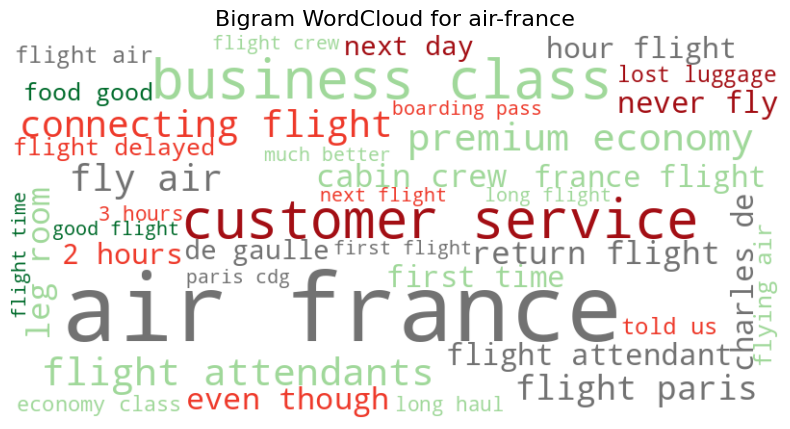

Bigram: air france, Avg. Rating: 2.53, Count: 2294
Bigram: flight delayed, Avg. Rating: 1.87, Count: 138
Bigram: connecting flight, Avg. Rating: 1.97, Count: 226
Bigram: customer service, Avg. Rating: 1.46, Count: 564
Bigram: lost luggage, Avg. Rating: 1.26, Count: 120
Bigram: flight air, Avg. Rating: 2.69, Count: 127
Bigram: business class, Avg. Rating: 2.90, Count: 500
Bigram: long haul, Avg. Rating: 2.84, Count: 103
Bigram: first time, Avg. Rating: 2.84, Count: 174
Bigram: cabin crew, Avg. Rating: 3.33, Count: 181
Bigram: next flight, Avg. Rating: 2.03, Count: 95
Bigram: first flight, Avg. Rating: 2.28, Count: 90
Bigram: flight paris, Avg. Rating: 2.35, Count: 214
Bigram: next day, Avg. Rating: 1.43, Count: 122
Bigram: told us, Avg. Rating: 1.56, Count: 101
Bigram: even though, Avg. Rating: 2.00, Count: 177
Bigram: premium economy, Avg. Rating: 3.08, Count: 224
Bigram: boarding pass, Avg. Rating: 2.15, Count: 80
Bigram: de gaulle, Avg. Rating: 2.69, Count: 131
Bigram: 3 hours, Avg. 

In [17]:
generate_bigram_wordcloud(data, 'air-france', 100)

<ipython-input-16-db88c754cc4b>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  company_data['cleaned_review_text'] = company_data['review_text'].dropna().apply(preprocess_text)


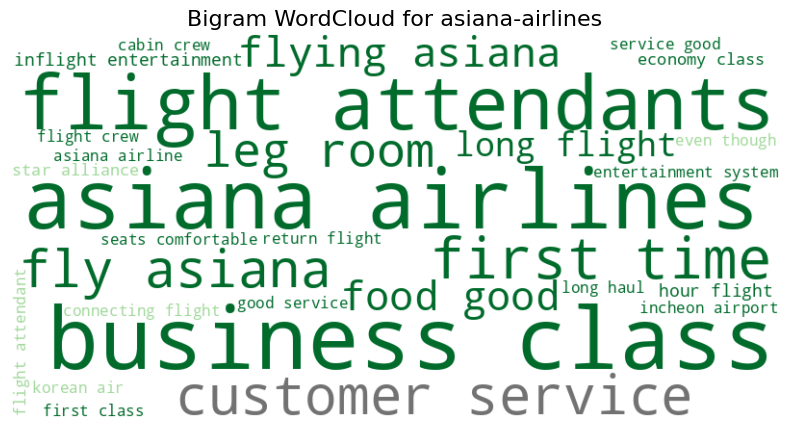

Bigram: customer service, Avg. Rating: 2.37, Count: 103
Bigram: fly asiana, Avg. Rating: 3.92, Count: 117
Bigram: return flight, Avg. Rating: 3.51, Count: 57
Bigram: connecting flight, Avg. Rating: 3.25, Count: 51
Bigram: flying asiana, Avg. Rating: 4.05, Count: 88
Bigram: incheon airport, Avg. Rating: 3.73, Count: 51
Bigram: economy class, Avg. Rating: 4.18, Count: 76
Bigram: flight attendants, Avg. Rating: 4.25, Count: 237
Bigram: asiana airlines, Avg. Rating: 3.75, Count: 227
Bigram: business class, Avg. Rating: 3.96, Count: 233
Bigram: flight crew, Avg. Rating: 4.20, Count: 54
Bigram: long haul, Avg. Rating: 3.96, Count: 53
Bigram: star alliance, Avg. Rating: 3.48, Count: 60
Bigram: even though, Avg. Rating: 3.00, Count: 54
Bigram: first time, Avg. Rating: 4.19, Count: 132
Bigram: inflight entertainment, Avg. Rating: 3.84, Count: 82
Bigram: leg room, Avg. Rating: 4.21, Count: 100
Bigram: cabin crew, Avg. Rating: 4.06, Count: 64
Bigram: good service, Avg. Rating: 4.14, Count: 51
Big

In [18]:
generate_bigram_wordcloud(data, 'asiana-airlines', 50)

<ipython-input-16-db88c754cc4b>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  company_data['cleaned_review_text'] = company_data['review_text'].dropna().apply(preprocess_text)


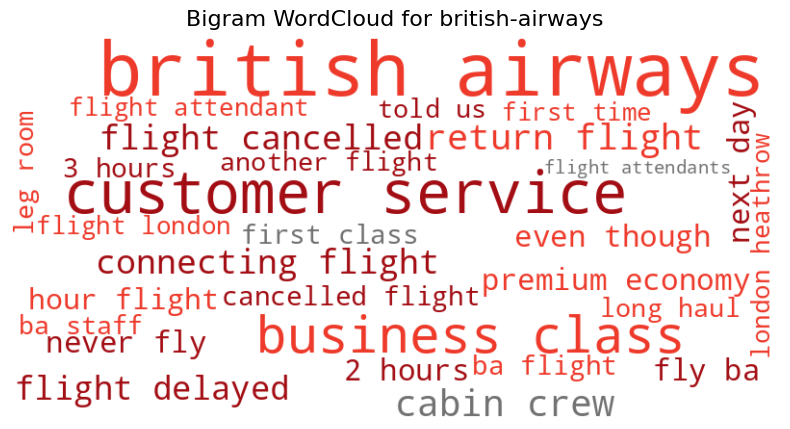

Bigram: flight delayed, Avg. Rating: 1.46, Count: 288
Bigram: hour flight, Avg. Rating: 1.80, Count: 214
Bigram: flight attendants, Avg. Rating: 2.38, Count: 141
Bigram: customer service, Avg. Rating: 1.29, Count: 972
Bigram: even though, Avg. Rating: 1.50, Count: 227
Bigram: british airways, Avg. Rating: 1.60, Count: 1280
Bigram: flight london, Avg. Rating: 1.58, Count: 143
Bigram: flight cancelled, Avg. Rating: 1.26, Count: 299
Bigram: business class, Avg. Rating: 1.94, Count: 573
Bigram: ba flight, Avg. Rating: 1.53, Count: 171
Bigram: another flight, Avg. Rating: 1.30, Count: 154
Bigram: flight attendant, Avg. Rating: 1.98, Count: 119
Bigram: leg room, Avg. Rating: 2.05, Count: 161
Bigram: 3 hours, Avg. Rating: 1.34, Count: 161
Bigram: cabin crew, Avg. Rating: 2.65, Count: 299
Bigram: long haul, Avg. Rating: 2.18, Count: 141
Bigram: return flight, Avg. Rating: 1.65, Count: 341
Bigram: 2 hours, Avg. Rating: 1.32, Count: 234
Bigram: connecting flight, Avg. Rating: 1.26, Count: 266
Bi

In [19]:
generate_bigram_wordcloud(data, 'british-airways', 150)

<ipython-input-16-db88c754cc4b>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  company_data['cleaned_review_text'] = company_data['review_text'].dropna().apply(preprocess_text)


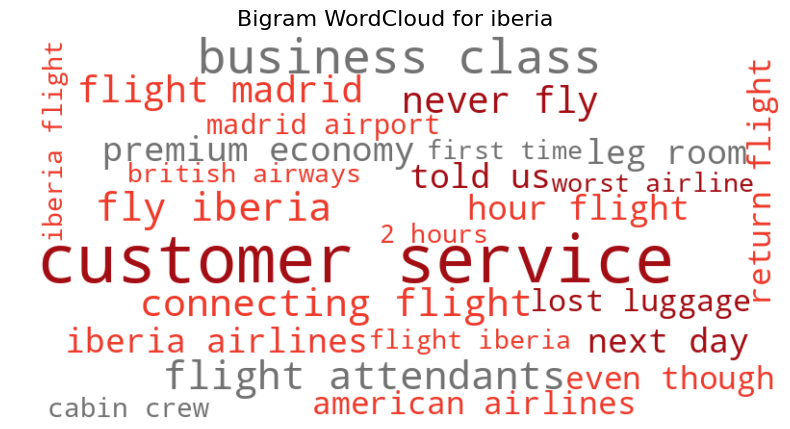

Bigram: customer service, Avg. Rating: 1.28, Count: 885
Bigram: fly iberia, Avg. Rating: 1.72, Count: 319
Bigram: madrid airport, Avg. Rating: 1.93, Count: 163
Bigram: connecting flight, Avg. Rating: 1.65, Count: 238
Bigram: lost luggage, Avg. Rating: 1.23, Count: 162
Bigram: business class, Avg. Rating: 2.60, Count: 362
Bigram: iberia flight, Avg. Rating: 2.02, Count: 130
Bigram: flight attendants, Avg. Rating: 2.49, Count: 294
Bigram: next day, Avg. Rating: 1.32, Count: 180
Bigram: premium economy, Avg. Rating: 2.42, Count: 145
Bigram: never fly, Avg. Rating: 1.16, Count: 269
Bigram: first time, Avg. Rating: 2.51, Count: 162
Bigram: worst airline, Avg. Rating: 1.06, Count: 152
Bigram: flight iberia, Avg. Rating: 2.00, Count: 147
Bigram: even though, Avg. Rating: 1.60, Count: 192
Bigram: flight madrid, Avg. Rating: 1.91, Count: 256
Bigram: 2 hours, Avg. Rating: 1.65, Count: 152
Bigram: return flight, Avg. Rating: 1.78, Count: 172
Bigram: told us, Avg. Rating: 1.21, Count: 169
Bigram: 

In [20]:
generate_bigram_wordcloud(data, 'iberia', 150)

<ipython-input-16-db88c754cc4b>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  company_data['cleaned_review_text'] = company_data['review_text'].dropna().apply(preprocess_text)


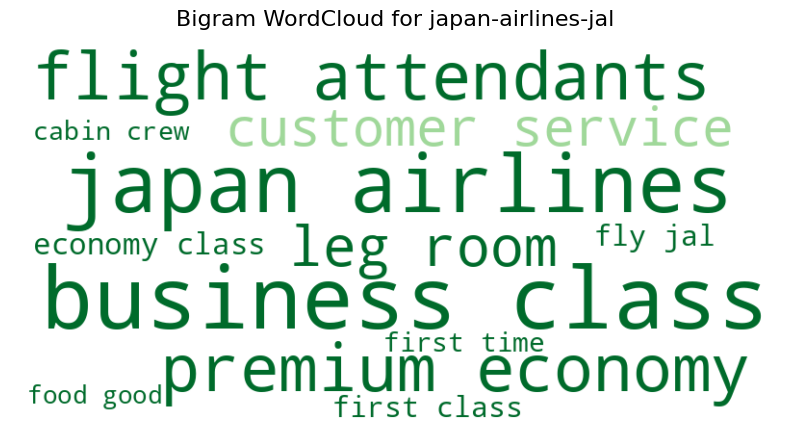

Bigram: japan airlines, Avg. Rating: 4.05, Count: 441
Bigram: customer service, Avg. Rating: 3.22, Count: 207
Bigram: business class, Avg. Rating: 3.96, Count: 465
Bigram: flight attendants, Avg. Rating: 4.46, Count: 352
Bigram: cabin crew, Avg. Rating: 4.40, Count: 159
Bigram: premium economy, Avg. Rating: 4.29, Count: 271
Bigram: economy class, Avg. Rating: 4.37, Count: 212
Bigram: first time, Avg. Rating: 4.31, Count: 195
Bigram: fly jal, Avg. Rating: 4.14, Count: 221
Bigram: first class, Avg. Rating: 4.53, Count: 161
Bigram: food good, Avg. Rating: 4.53, Count: 158
Bigram: leg room, Avg. Rating: 4.52, Count: 261


In [21]:
generate_bigram_wordcloud(data, 'japan-airlines-jal', 150)

<ipython-input-16-db88c754cc4b>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  company_data['cleaned_review_text'] = company_data['review_text'].dropna().apply(preprocess_text)


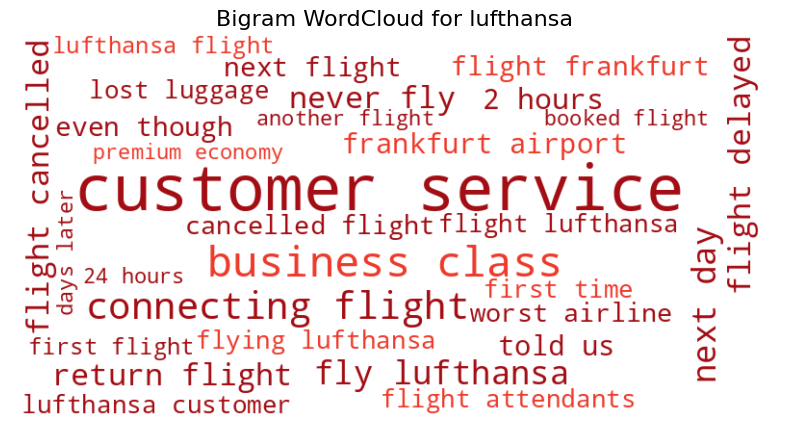

Bigram: flight attendants, Avg. Rating: 2.19, Count: 167
Bigram: customer service, Avg. Rating: 1.18, Count: 1208
Bigram: premium economy, Avg. Rating: 1.98, Count: 116
Bigram: first time, Avg. Rating: 1.75, Count: 165
Bigram: next day, Avg. Rating: 1.19, Count: 283
Bigram: return flight, Avg. Rating: 1.34, Count: 225
Bigram: even though, Avg. Rating: 1.35, Count: 186
Bigram: frankfurt airport, Avg. Rating: 1.52, Count: 184
Bigram: flying lufthansa, Avg. Rating: 1.61, Count: 169
Bigram: connecting flight, Avg. Rating: 1.46, Count: 356
Bigram: 24 hours, Avg. Rating: 1.14, Count: 135
Bigram: business class, Avg. Rating: 1.91, Count: 381
Bigram: worst airline, Avg. Rating: 1.05, Count: 192
Bigram: flight delayed, Avg. Rating: 1.30, Count: 260
Bigram: told us, Avg. Rating: 1.24, Count: 165
Bigram: never fly, Avg. Rating: 1.06, Count: 279
Bigram: booked flight, Avg. Rating: 1.23, Count: 149
Bigram: flight cancelled, Avg. Rating: 1.17, Count: 255
Bigram: another flight, Avg. Rating: 1.24, Co

In [22]:
generate_bigram_wordcloud(data, 'lufthansa', 150)

<ipython-input-16-db88c754cc4b>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  company_data['cleaned_review_text'] = company_data['review_text'].dropna().apply(preprocess_text)


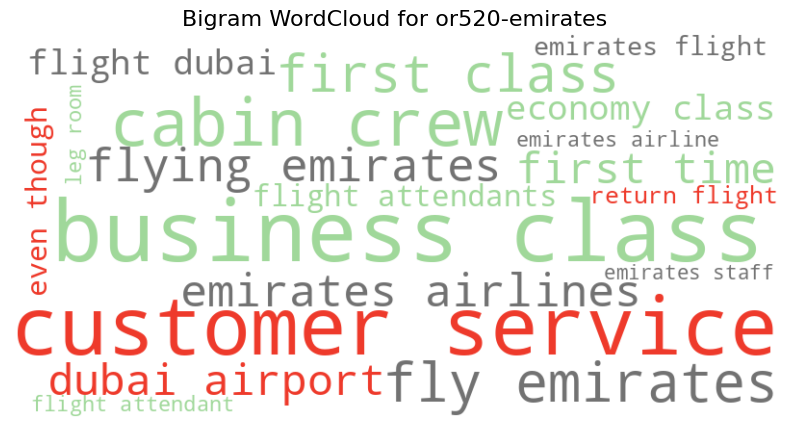

Bigram: economy class, Avg. Rating: 3.13, Count: 173
Bigram: dubai airport, Avg. Rating: 2.13, Count: 191
Bigram: first time, Avg. Rating: 2.86, Count: 219
Bigram: cabin crew, Avg. Rating: 3.10, Count: 394
Bigram: customer service, Avg. Rating: 1.69, Count: 598
Bigram: flying emirates, Avg. Rating: 2.63, Count: 242
Bigram: flight attendants, Avg. Rating: 3.00, Count: 168
Bigram: flight attendant, Avg. Rating: 2.99, Count: 134
Bigram: emirates staff, Avg. Rating: 2.25, Count: 129
Bigram: business class, Avg. Rating: 2.96, Count: 579
Bigram: emirates airlines, Avg. Rating: 2.37, Count: 199
Bigram: emirates airline, Avg. Rating: 2.24, Count: 136
Bigram: flight dubai, Avg. Rating: 2.27, Count: 201
Bigram: emirates flight, Avg. Rating: 2.47, Count: 158
Bigram: first class, Avg. Rating: 3.26, Count: 211
Bigram: return flight, Avg. Rating: 2.05, Count: 161
Bigram: even though, Avg. Rating: 2.00, Count: 167
Bigram: fly emirates, Avg. Rating: 2.46, Count: 322
Bigram: leg room, Avg. Rating: 3.36

In [23]:
generate_bigram_wordcloud(data, 'or520-emirates', 150)

<ipython-input-16-db88c754cc4b>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  company_data['cleaned_review_text'] = company_data['review_text'].dropna().apply(preprocess_text)


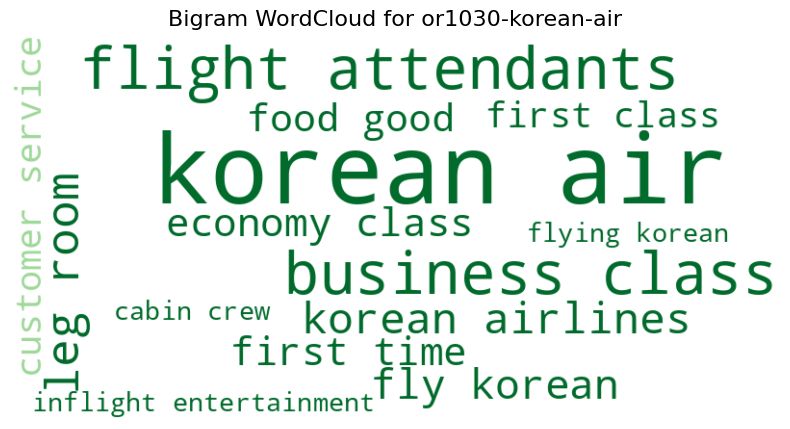

Bigram: customer service, Avg. Rating: 3.24, Count: 142
Bigram: flight attendants, Avg. Rating: 4.35, Count: 433
Bigram: cabin crew, Avg. Rating: 4.22, Count: 141
Bigram: korean air, Avg. Rating: 4.20, Count: 1394
Bigram: flying korean, Avg. Rating: 4.25, Count: 155
Bigram: first time, Avg. Rating: 4.26, Count: 207
Bigram: korean airlines, Avg. Rating: 4.02, Count: 195
Bigram: fly korean, Avg. Rating: 4.19, Count: 224
Bigram: business class, Avg. Rating: 3.98, Count: 352
Bigram: economy class, Avg. Rating: 4.51, Count: 166
Bigram: leg room, Avg. Rating: 4.55, Count: 263
Bigram: food good, Avg. Rating: 4.46, Count: 200
Bigram: inflight entertainment, Avg. Rating: 4.43, Count: 161
Bigram: first class, Avg. Rating: 4.35, Count: 115


In [24]:
generate_bigram_wordcloud(data, 'or1030-korean-air', 150)

<ipython-input-16-db88c754cc4b>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  company_data['cleaned_review_text'] = company_data['review_text'].dropna().apply(preprocess_text)


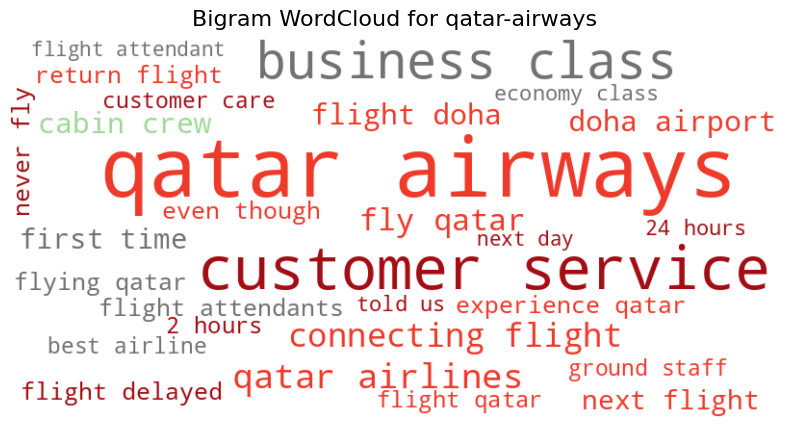

Bigram: flight attendants, Avg. Rating: 2.63, Count: 179
Bigram: qatar airlines, Avg. Rating: 1.74, Count: 301
Bigram: customer service, Avg. Rating: 1.43, Count: 1115
Bigram: qatar airways, Avg. Rating: 1.98, Count: 1812
Bigram: customer care, Avg. Rating: 1.22, Count: 136
Bigram: never fly, Avg. Rating: 1.09, Count: 198
Bigram: fly qatar, Avg. Rating: 1.89, Count: 295
Bigram: connecting flight, Avg. Rating: 1.56, Count: 293
Bigram: flight doha, Avg. Rating: 2.03, Count: 261
Bigram: 24 hours, Avg. Rating: 1.18, Count: 136
Bigram: experience qatar, Avg. Rating: 1.96, Count: 201
Bigram: doha airport, Avg. Rating: 1.98, Count: 233
Bigram: return flight, Avg. Rating: 1.68, Count: 182
Bigram: flight qatar, Avg. Rating: 1.97, Count: 165
Bigram: business class, Avg. Rating: 2.55, Count: 624
Bigram: flight delayed, Avg. Rating: 1.35, Count: 192
Bigram: even though, Avg. Rating: 1.55, Count: 193
Bigram: first time, Avg. Rating: 2.39, Count: 252
Bigram: 2 hours, Avg. Rating: 1.42, Count: 161
Bi

In [25]:
generate_bigram_wordcloud(data, 'qatar-airways', 150)

<ipython-input-16-db88c754cc4b>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  company_data['cleaned_review_text'] = company_data['review_text'].dropna().apply(preprocess_text)


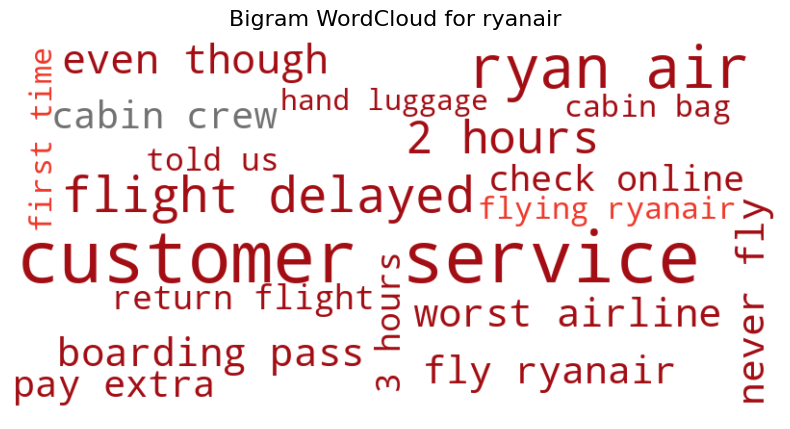

Bigram: flying ryanair, Avg. Rating: 1.67, Count: 149
Bigram: customer service, Avg. Rating: 1.18, Count: 711
Bigram: cabin bag, Avg. Rating: 1.24, Count: 102
Bigram: even though, Avg. Rating: 1.21, Count: 239
Bigram: never fly, Avg. Rating: 1.08, Count: 223
Bigram: boarding pass, Avg. Rating: 1.27, Count: 174
Bigram: worst airline, Avg. Rating: 1.03, Count: 231
Bigram: fly ryanair, Avg. Rating: 1.38, Count: 224
Bigram: cabin crew, Avg. Rating: 2.42, Count: 172
Bigram: flight delayed, Avg. Rating: 1.26, Count: 329
Bigram: ryan air, Avg. Rating: 1.32, Count: 355
Bigram: check online, Avg. Rating: 1.18, Count: 168
Bigram: 2 hours, Avg. Rating: 1.15, Count: 289
Bigram: told us, Avg. Rating: 1.11, Count: 129
Bigram: hand luggage, Avg. Rating: 1.21, Count: 122
Bigram: return flight, Avg. Rating: 1.46, Count: 164
Bigram: pay extra, Avg. Rating: 1.23, Count: 200
Bigram: first time, Avg. Rating: 1.77, Count: 147
Bigram: 3 hours, Avg. Rating: 1.18, Count: 163


In [26]:
generate_bigram_wordcloud(data, 'ryanair', 150)

<ipython-input-16-db88c754cc4b>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  company_data['cleaned_review_text'] = company_data['review_text'].dropna().apply(preprocess_text)


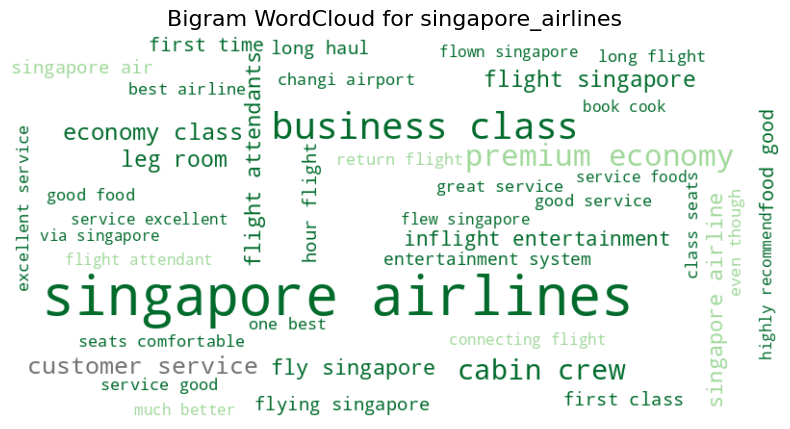

Bigram: economy class, Avg. Rating: 3.82, Count: 359
Bigram: premium economy, Avg. Rating: 3.50, Count: 584
Bigram: singapore air, Avg. Rating: 3.38, Count: 230
Bigram: flight singapore, Avg. Rating: 3.54, Count: 408
Bigram: singapore airlines, Avg. Rating: 3.71, Count: 2779
Bigram: customer service, Avg. Rating: 2.45, Count: 453
Bigram: flight attendants, Avg. Rating: 4.19, Count: 342
Bigram: flight attendant, Avg. Rating: 3.23, Count: 125
Bigram: connecting flight, Avg. Rating: 2.87, Count: 140
Bigram: leg room, Avg. Rating: 4.02, Count: 417
Bigram: long haul, Avg. Rating: 4.12, Count: 275
Bigram: business class, Avg. Rating: 3.67, Count: 896
Bigram: flying singapore, Avg. Rating: 4.01, Count: 294
Bigram: singapore airline, Avg. Rating: 3.38, Count: 323
Bigram: one best, Avg. Rating: 4.20, Count: 201
Bigram: class seats, Avg. Rating: 3.81, Count: 120
Bigram: return flight, Avg. Rating: 3.14, Count: 219
Bigram: flew singapore, Avg. Rating: 3.93, Count: 166
Bigram: first class, Avg. Ra

In [27]:
generate_bigram_wordcloud(data, 'singapore_airlines', 150)

<ipython-input-16-db88c754cc4b>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  company_data['cleaned_review_text'] = company_data['review_text'].dropna().apply(preprocess_text)


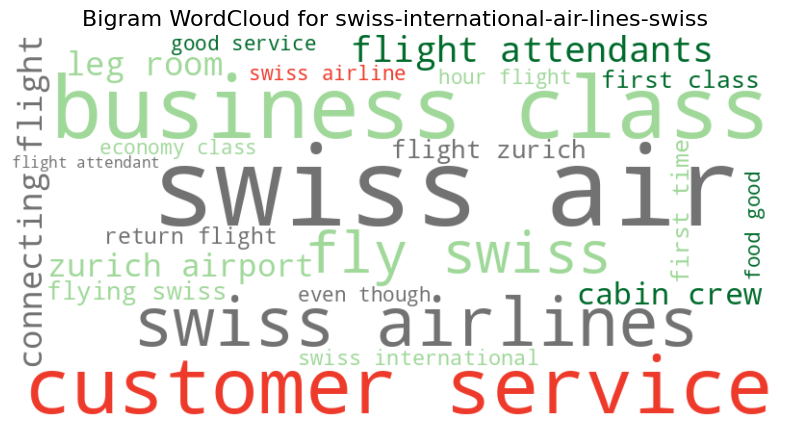

Bigram: flight zurich, Avg. Rating: 2.73, Count: 198
Bigram: swiss air, Avg. Rating: 2.66, Count: 846
Bigram: flight attendant, Avg. Rating: 2.56, Count: 118
Bigram: customer service, Avg. Rating: 1.58, Count: 487
Bigram: business class, Avg. Rating: 3.26, Count: 525
Bigram: leg room, Avg. Rating: 3.42, Count: 196
Bigram: first time, Avg. Rating: 3.35, Count: 194
Bigram: swiss airlines, Avg. Rating: 2.39, Count: 313
Bigram: swiss international, Avg. Rating: 3.16, Count: 104
Bigram: connecting flight, Avg. Rating: 2.33, Count: 187
Bigram: first class, Avg. Rating: 3.70, Count: 138
Bigram: economy class, Avg. Rating: 3.35, Count: 137
Bigram: zurich airport, Avg. Rating: 3.08, Count: 195
Bigram: swiss airline, Avg. Rating: 2.14, Count: 113
Bigram: even though, Avg. Rating: 2.39, Count: 146
Bigram: food good, Avg. Rating: 4.18, Count: 155
Bigram: fly swiss, Avg. Rating: 2.91, Count: 302
Bigram: return flight, Avg. Rating: 2.63, Count: 150
Bigram: cabin crew, Avg. Rating: 3.60, Count: 193
B

In [28]:
generate_bigram_wordcloud(data, 'swiss-international-air-lines-swiss', 150)

<ipython-input-16-db88c754cc4b>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  company_data['cleaned_review_text'] = company_data['review_text'].dropna().apply(preprocess_text)


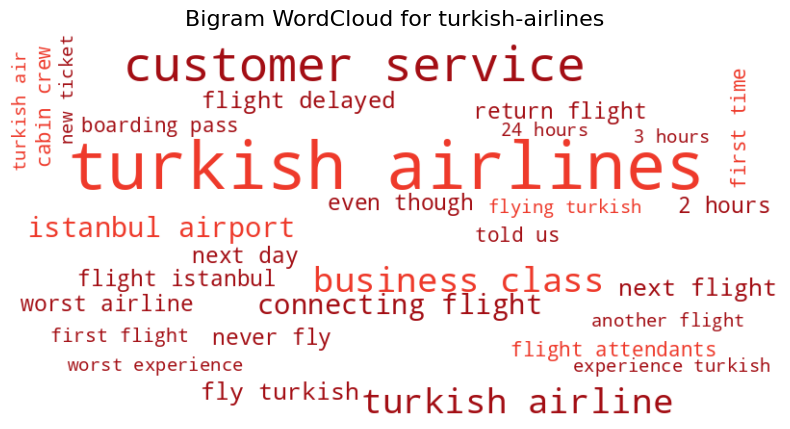

Bigram: customer service, Avg. Rating: 1.20, Count: 1283
Bigram: told us, Avg. Rating: 1.14, Count: 154
Bigram: business class, Avg. Rating: 1.91, Count: 438
Bigram: even though, Avg. Rating: 1.18, Count: 241
Bigram: experience turkish, Avg. Rating: 1.29, Count: 158
Bigram: turkish airlines, Avg. Rating: 1.50, Count: 2062
Bigram: first flight, Avg. Rating: 1.38, Count: 164
Bigram: flight istanbul, Avg. Rating: 1.46, Count: 235
Bigram: next flight, Avg. Rating: 1.22, Count: 250
Bigram: 3 hours, Avg. Rating: 1.30, Count: 145
Bigram: worst experience, Avg. Rating: 1.06, Count: 150
Bigram: new ticket, Avg. Rating: 1.07, Count: 137
Bigram: 2 hours, Avg. Rating: 1.33, Count: 214
Bigram: istanbul airport, Avg. Rating: 1.51, Count: 382
Bigram: next day, Avg. Rating: 1.11, Count: 219
Bigram: turkish airline, Avg. Rating: 1.29, Count: 505
Bigram: flight attendants, Avg. Rating: 1.81, Count: 176
Bigram: flight delayed, Avg. Rating: 1.17, Count: 253
Bigram: 24 hours, Avg. Rating: 1.19, Count: 145


In [29]:
generate_bigram_wordcloud(data, 'turkish-airlines', 150)

In [30]:
data.head()

title  departure destination  \
0                      Never travel  with Air France  Vancouver   New Delhi   
1                                   Terrible service    Chicago       Paris   
2                                          Traumatic     London     Algiers   
3  Air France,  the airline that keeps loosing lu...     London       Paris   
4                       ^^^^ Take Me  Home AF   ^^^^  Vancouver  Manchester   

   type_of_route                                        review_text  \
0  International  Worst Airline.stopped for door repair about 4 ...   
1  International  I boarded Air France on the 19th of December 2...   
2  International  A truly traumatic experience! So much that I g...   
3         Europe  Air France is quickly becoming the airline for...   
4  International  We had  surprisingly smooth  flight  with Air ...   

  travel_date review_date  rating  legroom_rating  seat_comfort_rating  \
0     2024-12  2024-12-21     1.0        1.000000             2.000000   
1     2024-12  2024-12-20     1.0        3.256587             3.118512   
2     2024-08  2024-12-19     2.0        1.000000             1.000000   
3     2024-12  2024-12-19     3.0        3.000000             3.000000   
4     2024-12  2024-12-19     4.0        4.000000             3.118512   

   entertainment_rating  customer_service_rating  value_rating  \
0              1.000000                  1.00000      1.000000   
1              3.121919                  3.08162      2.932936   
2              1.000000                  2.00000      1.000000   
3              3.000000                  4.00000      3.000000   
4              4.000000                  4.00000      4.000000   

   cleanliness_rating  check_in_rating  food_rating     company   satisfaction  
0            2.000000         1.000000     1.000000  air-france  Not Satisfied  
1            3.497865         3.217346     3.081991  air-france  Not Satisfied  
2            1.000000         1.000000     1.000000  air-france  Not Satisfied  
3            4.000000         3.000000     4.000000  air-france      Satisfied  
4            4.000000         4.000000     3.000000  air-france      Satisfied

In [31]:
# Compute the number of times a route is mentioned in a negative review
def bad_travels(data, company):
    # Filter data for the given company
    company_data_neg = data[(data['company'] == company) & (data['satisfaction'] == 'Not Satisfied')]
    company_data_pos = data[(data['company'] == company) & (data['satisfaction'] == 'Satisfied')]

    # Count negative and positive reviews for each route
    nb_neg = company_data_neg.groupby(['departure', 'destination']).size().reset_index(name='neg_count')
    nb_pos = company_data_pos.groupby(['departure', 'destination']).size().reset_index(name='pos_count')

    # Merge negative and positive counts
    merged_counts = pd.merge(nb_neg, nb_pos, on=['departure', 'destination'], how='outer').fillna(0)

    # Calculate the ratio of negative mentions to total mentions
    merged_counts['total_count'] = merged_counts['neg_count'] + merged_counts['pos_count']
    merged_counts['neg_ratio'] = merged_counts['neg_count'] / merged_counts['total_count']

    # Filter routes mentioned more than 50 times
    merged_counts_filtered = merged_counts[merged_counts['total_count'] > 50]

    # Sort by negative ratio
    merged_counts_sorted = merged_counts_filtered.sort_values(by='neg_ratio', ascending=False)

    # Select the top 10 routes
    top_10_routes = merged_counts_sorted.head(10)

    # Plot the top routes
    plt.figure(figsize=(12, 8))
    plt.bar(
        x=top_10_routes.apply(lambda row: f"{row['departure']} -> {row['destination']}", axis=1),
        height=top_10_routes['neg_ratio'],
        color='#FF9999',
        alpha=0.85
    )

    # Add titles and labels
    plt.title(f'Ratio a route is mentioned in a negative review (min 50 times) ({company})', fontsize=14)
    plt.ylabel('Ratio of Negative Mentions/Total Mentions', fontsize=12)
    plt.xlabel('Route', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

    # Show the plot
    plt.show()



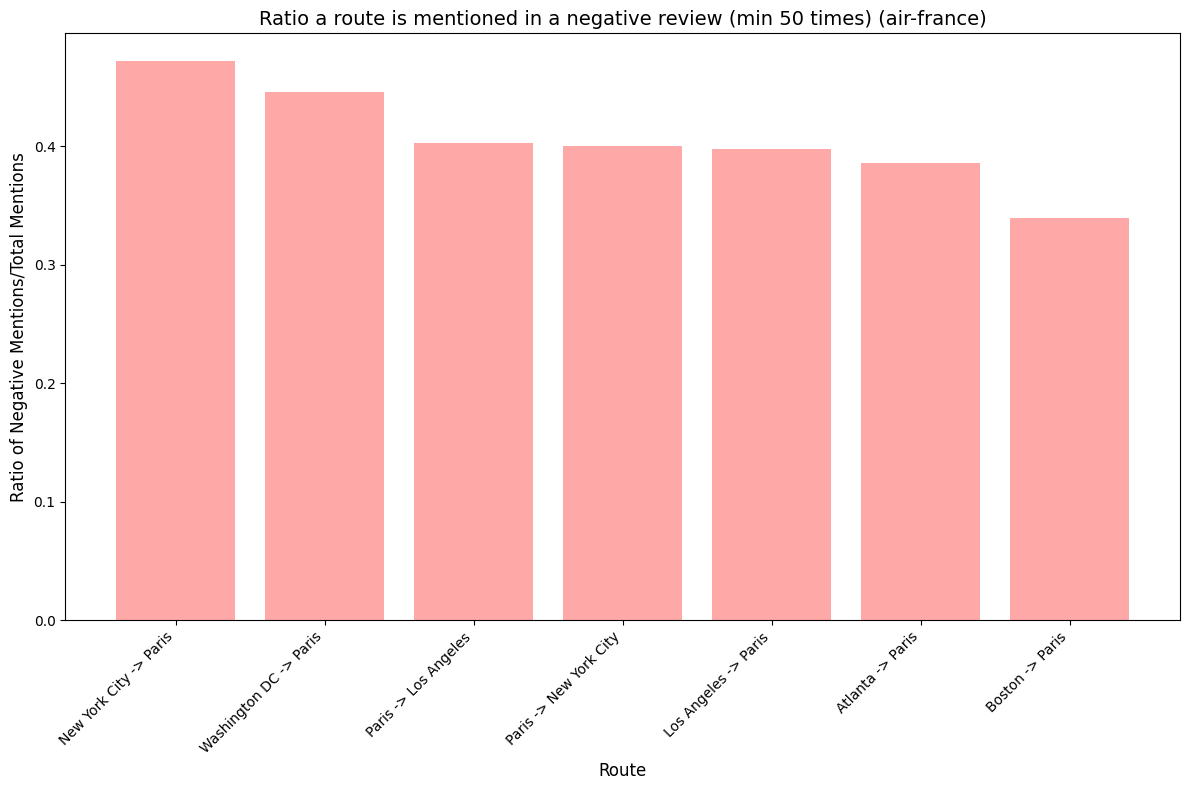

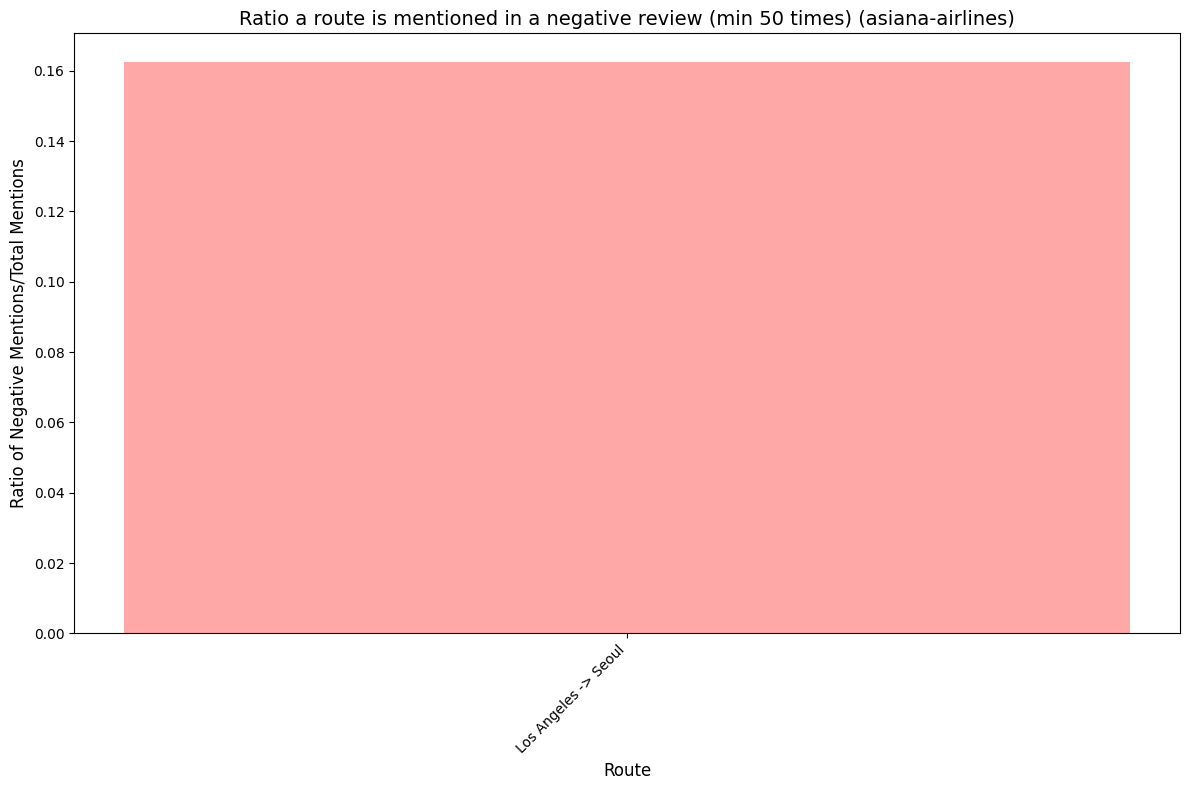

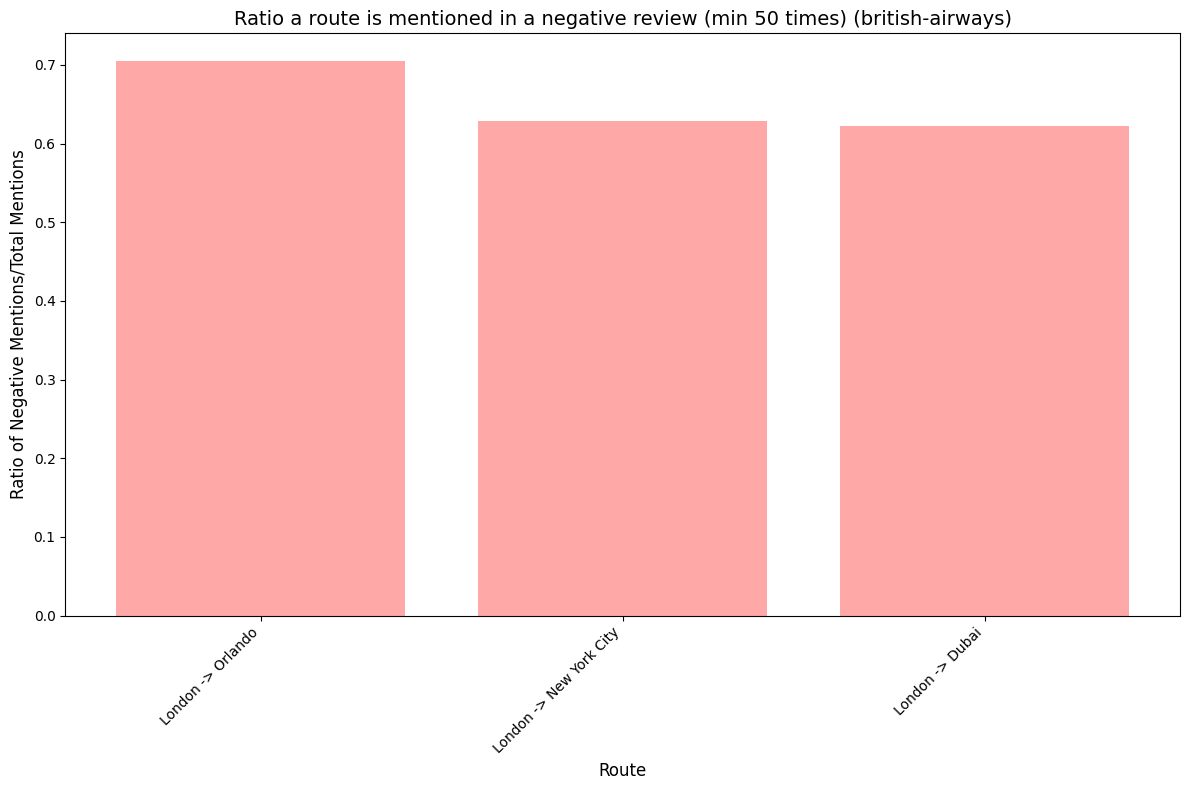

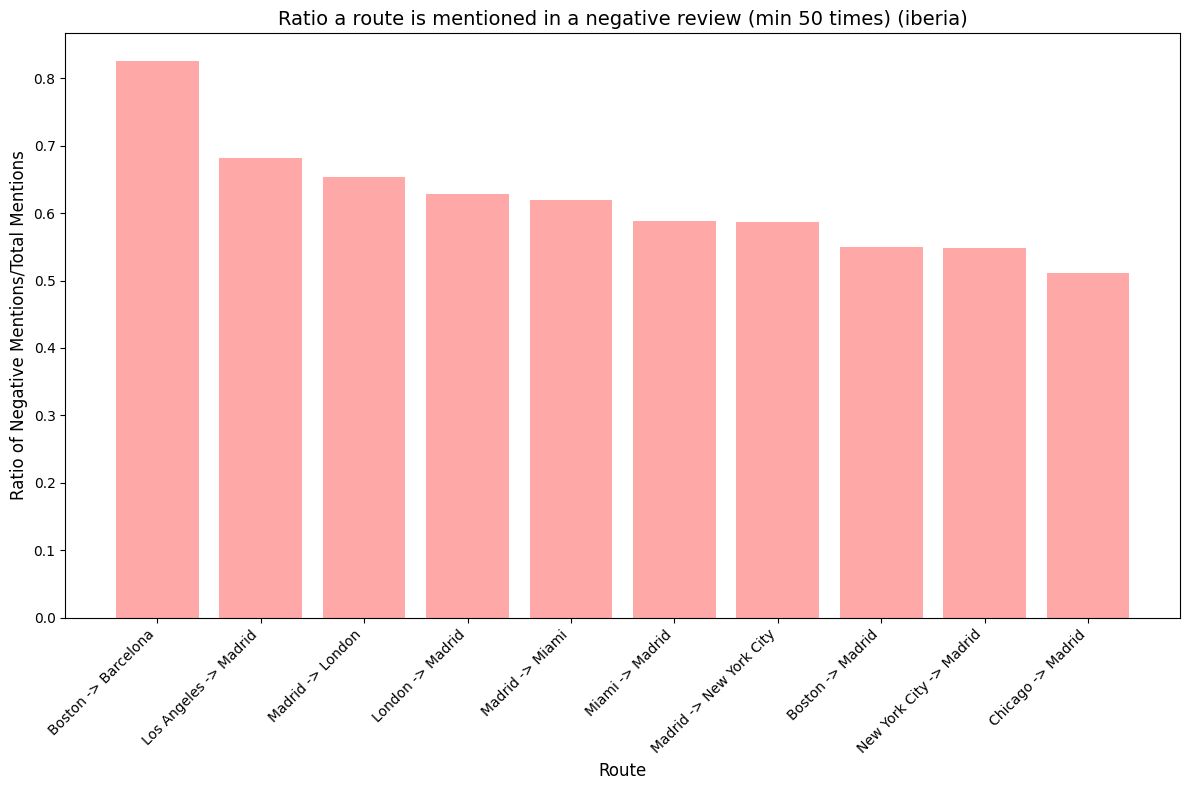

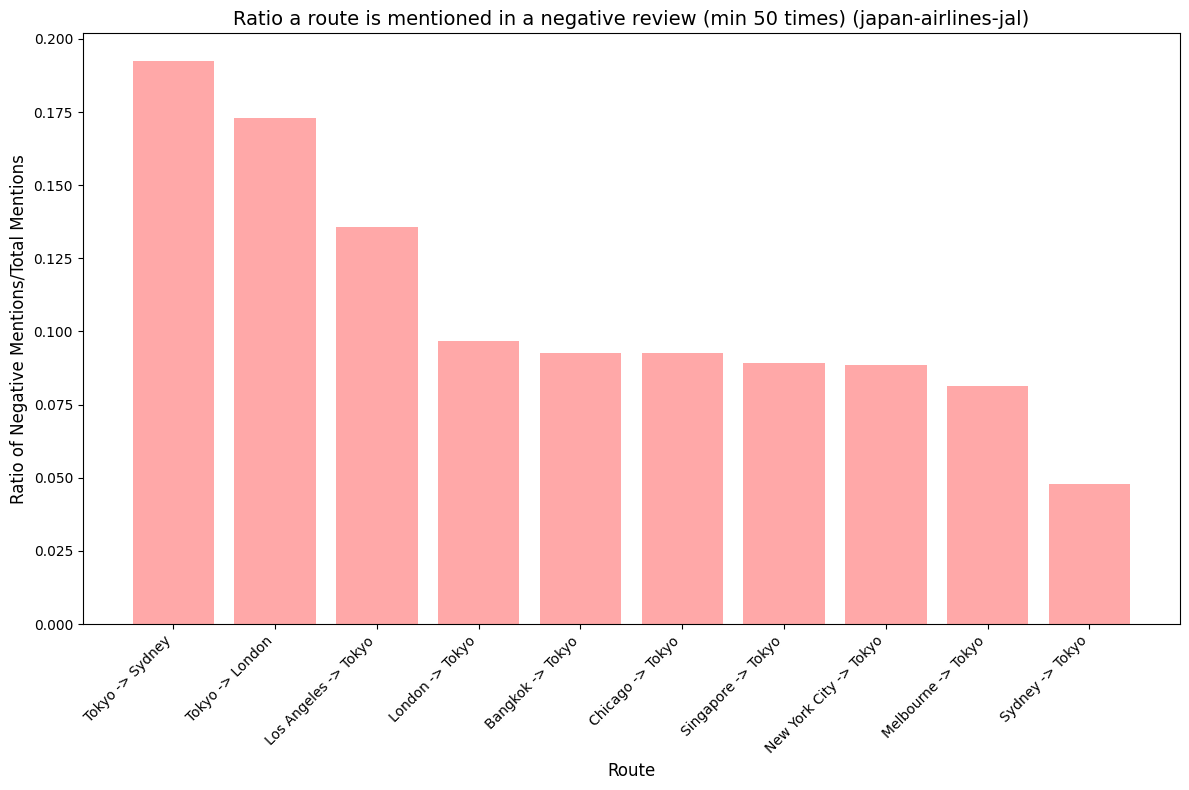

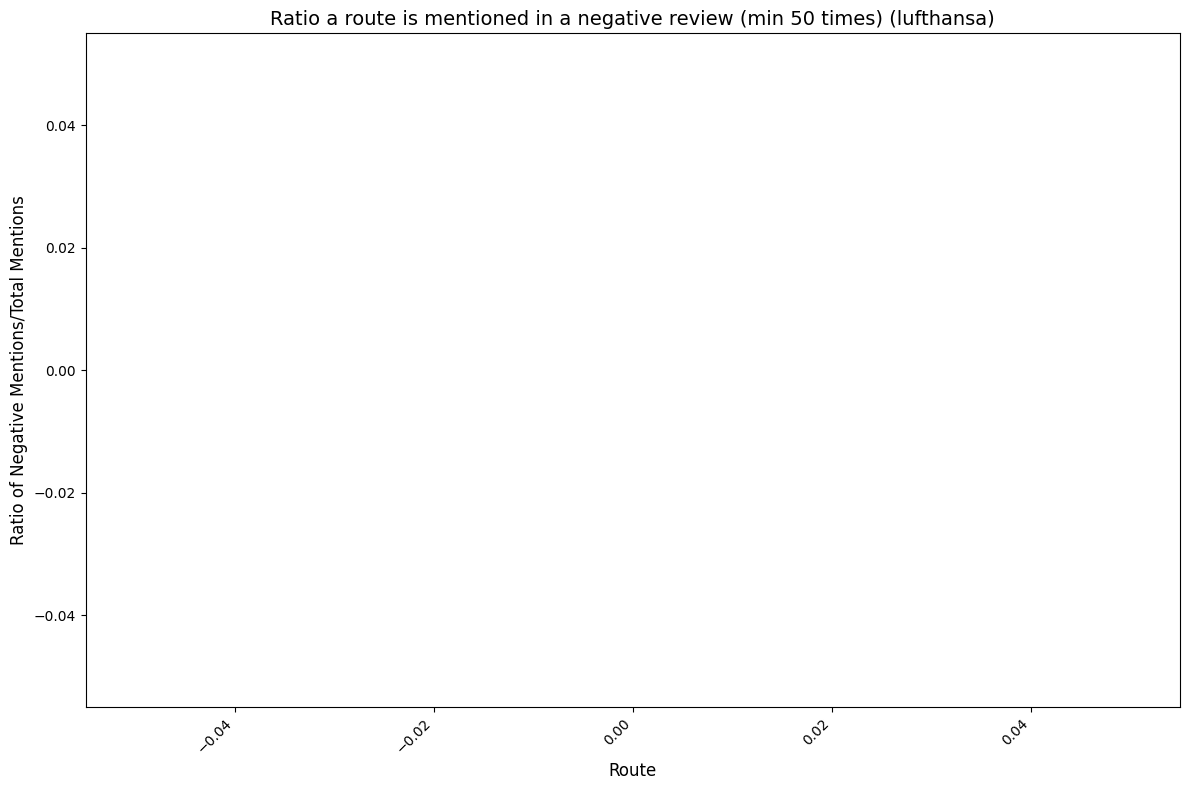

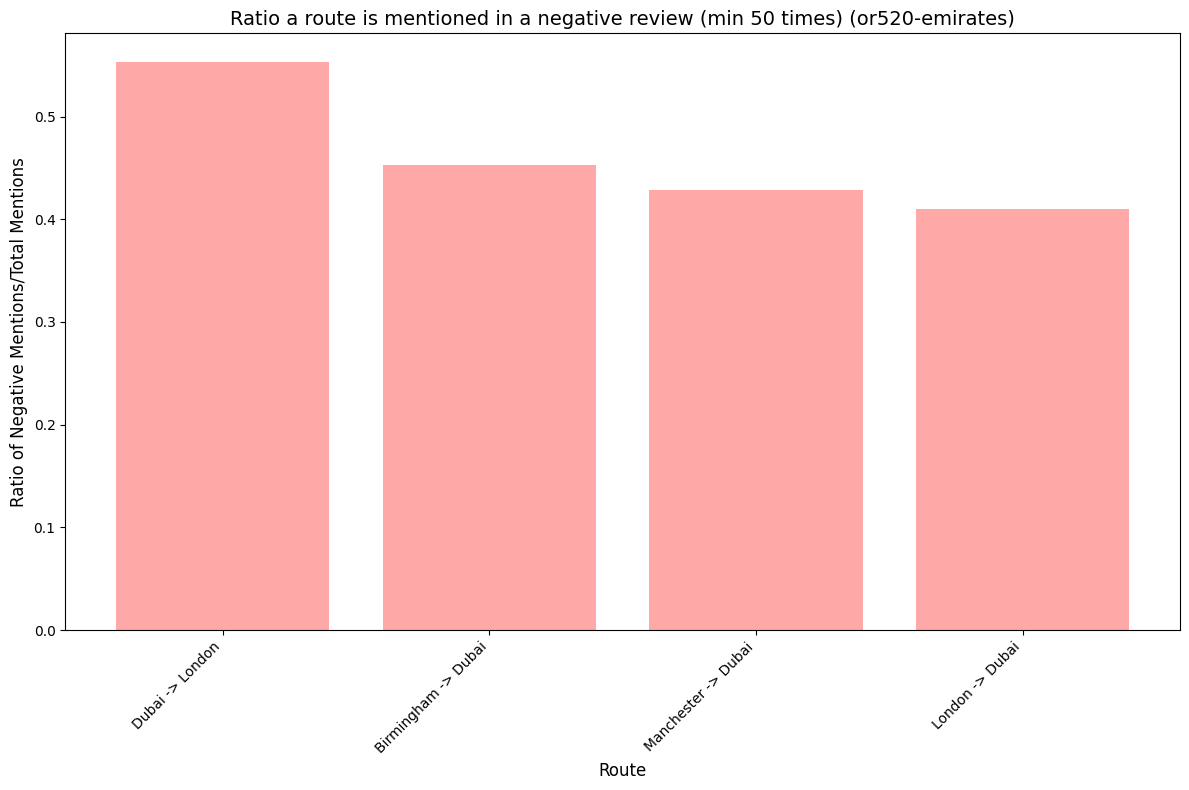

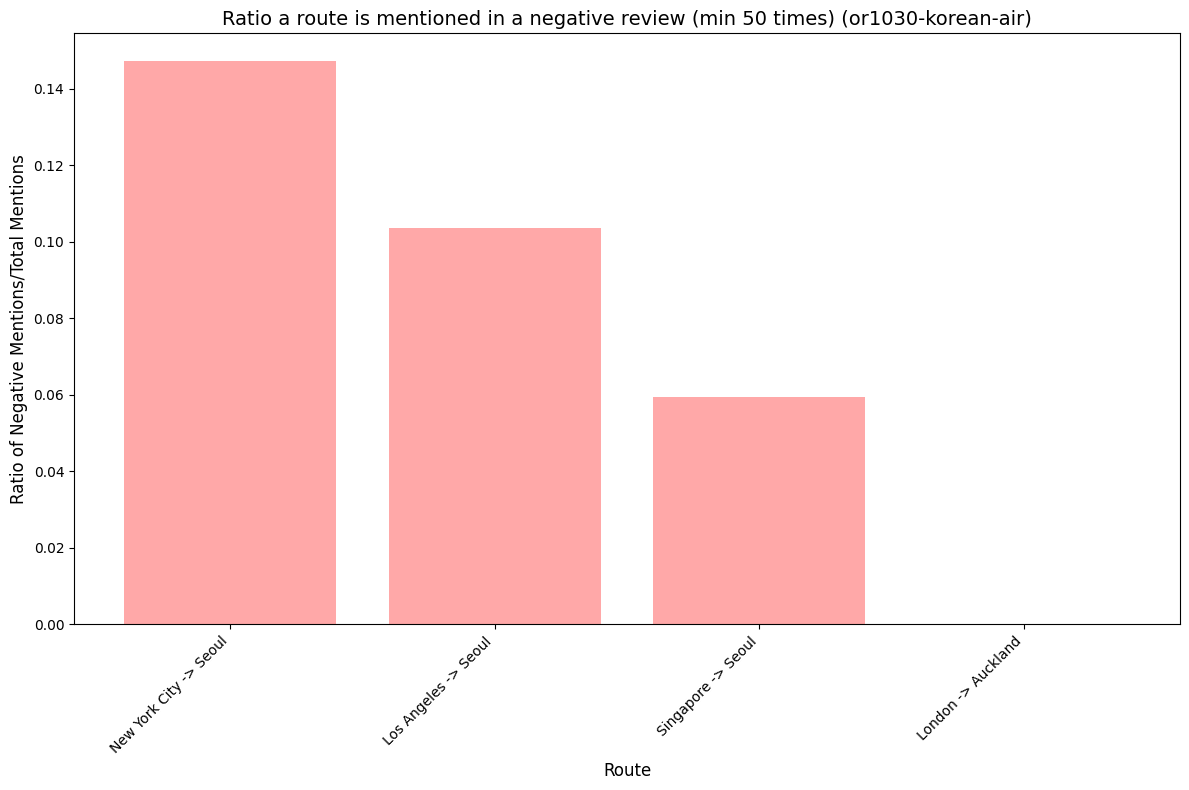

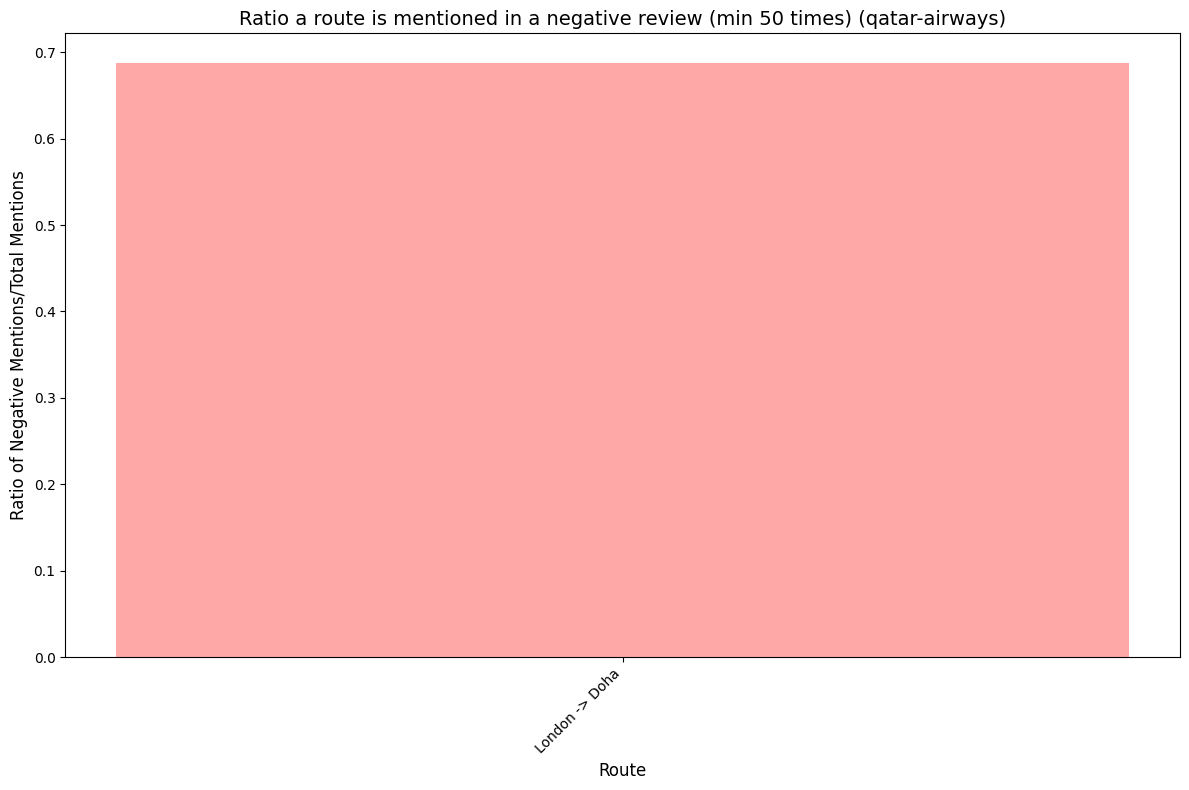

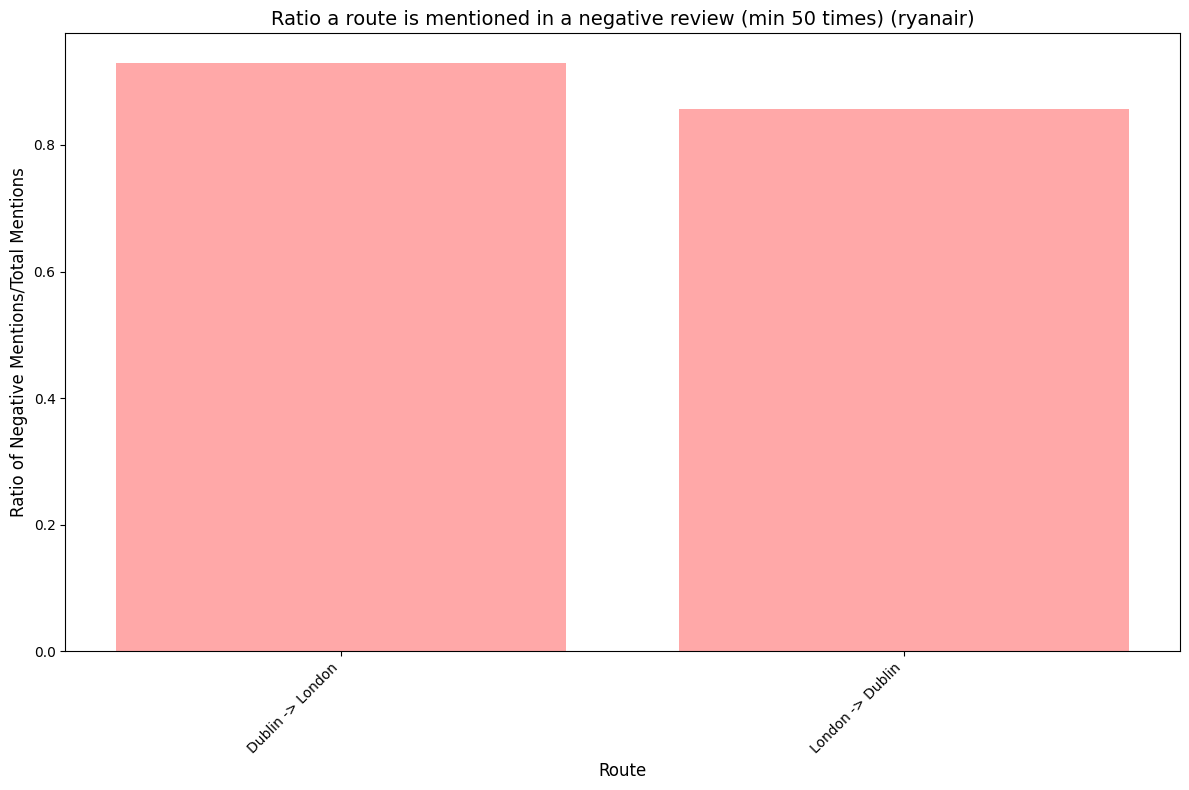

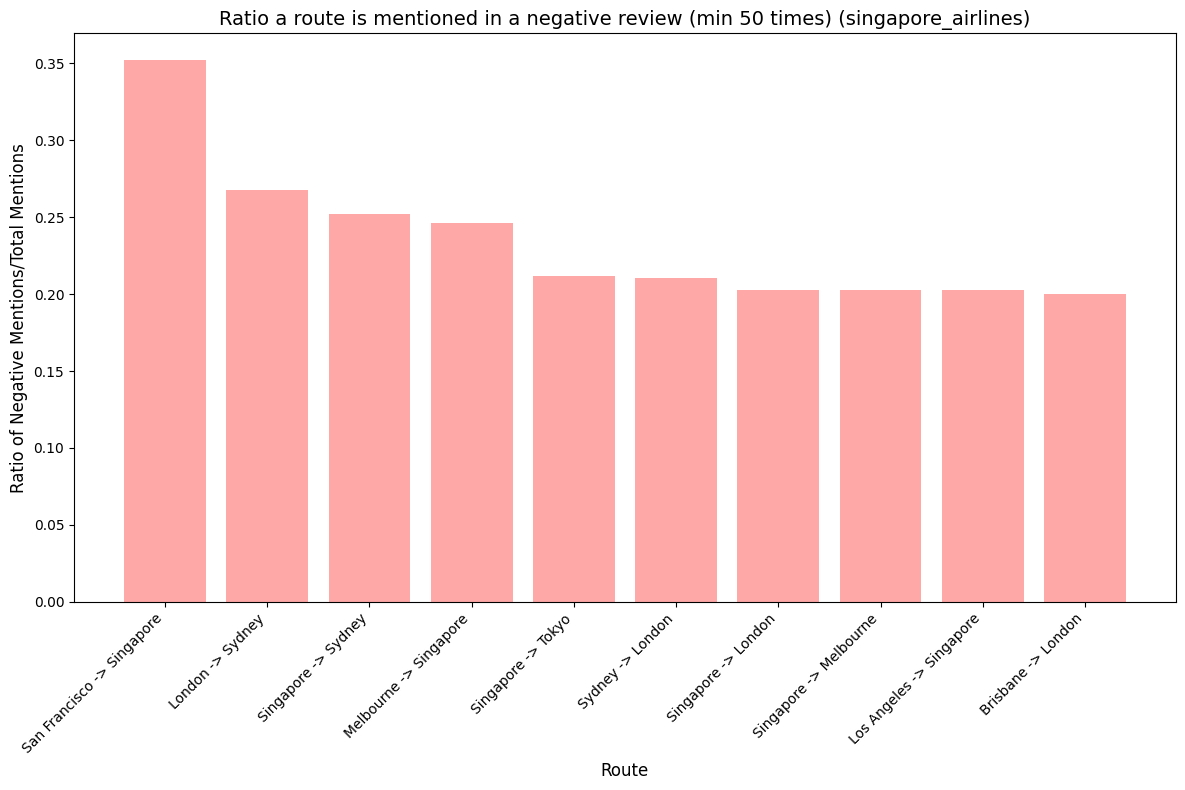

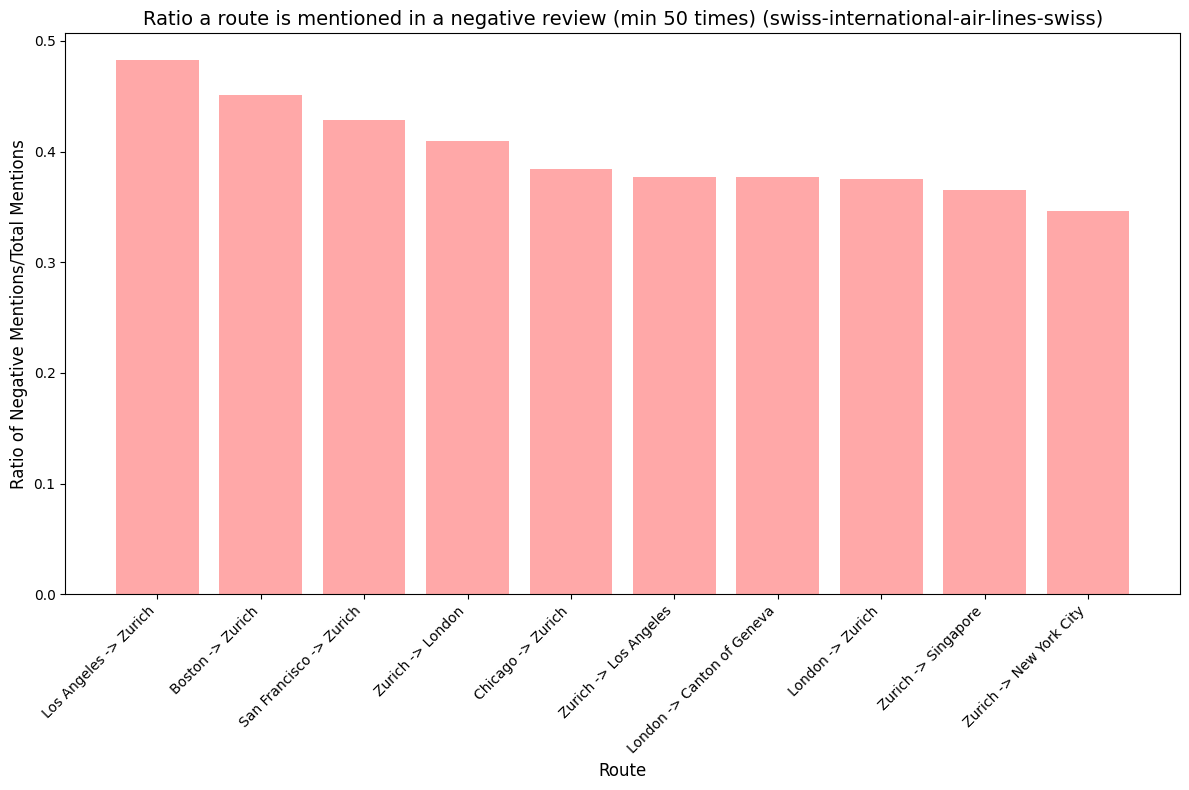

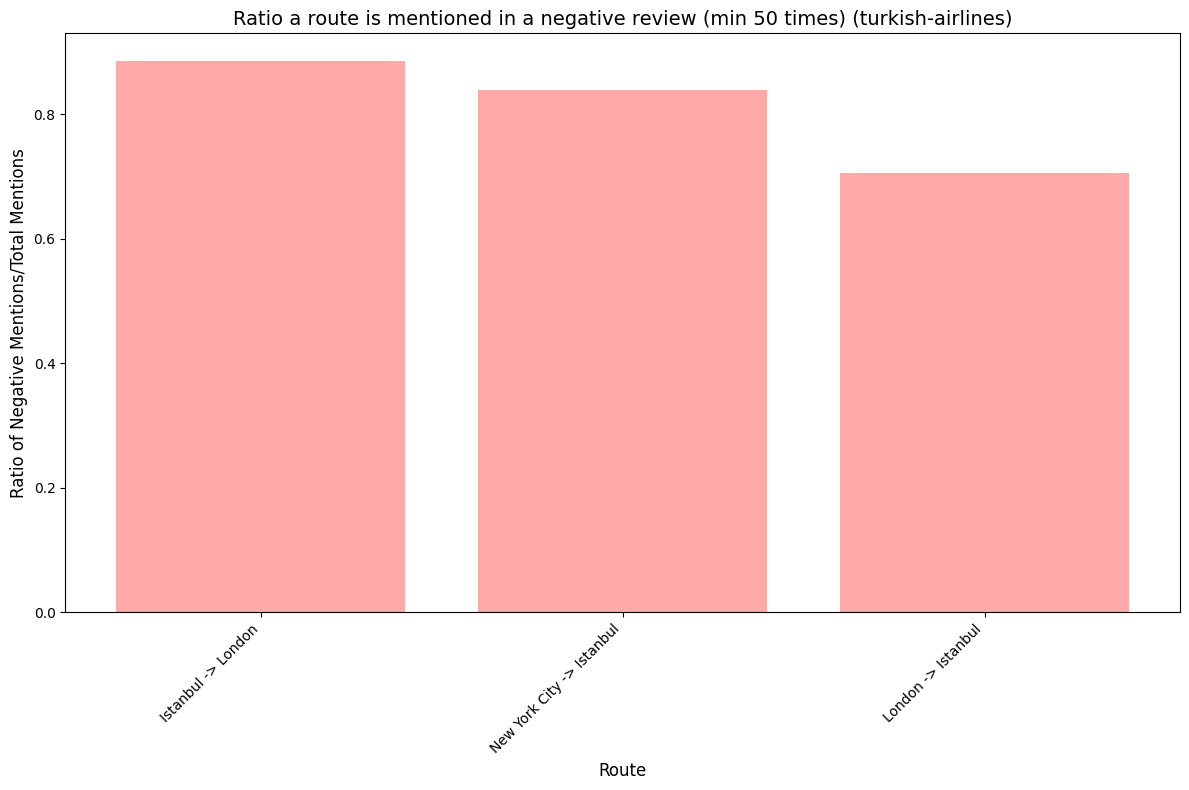

In [32]:
for company in companies:
    company_name = company
    bad_travels(data, company_name)

In [33]:
# Compute the number of times a route is mentioned in a positive review
def good_travels(data, company):
    # Filter data for the given company
    company_data_neg = data[(data['company'] == company) & (data['satisfaction'] == 'Not Satisfied')]
    company_data_pos = data[(data['company'] == company) & (data['satisfaction'] == 'Satisfied')]

    # Count negative and positive reviews for each route
    nb_neg = company_data_neg.groupby(['departure', 'destination']).size().reset_index(name='neg_count')
    nb_pos = company_data_pos.groupby(['departure', 'destination']).size().reset_index(name='pos_count')

    # Merge negative and positive counts
    merged_counts = pd.merge(nb_neg, nb_pos, on=['departure', 'destination'], how='outer').fillna(0)

    # Calculate the ratio of positive mentions to total mentions
    merged_counts['total_count'] = merged_counts['neg_count'] + merged_counts['pos_count']
    merged_counts['pos_ratio'] = merged_counts['pos_count'] / merged_counts['total_count']

    # Filter routes mentioned more than 50 times
    merged_counts_filtered = merged_counts[merged_counts['total_count'] > 50]

    # Sort by positive ratio
    merged_counts_sorted = merged_counts_filtered.sort_values(by='pos_ratio', ascending=False)

    # Select the top 10 routes
    top_10_routes = merged_counts_sorted.head(10)

    # Plot the top routes
    plt.figure(figsize=(12, 8))
    plt.bar(
        x=top_10_routes.apply(lambda row: f"{row['departure']} -> {row['destination']}", axis=1),
        height=top_10_routes['pos_ratio'],
        color='#66B3FF',
        alpha=0.85
    )

    # Add titles and labels
    plt.title(f'Ratio a route is mentioned in a positive review (min 50 times) ({company})', fontsize=14)
    plt.ylabel('Ratio of Positive Mentions/Total Mentions', fontsize=12)
    plt.xlabel('Route', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

    # Show the plot
    plt.show()

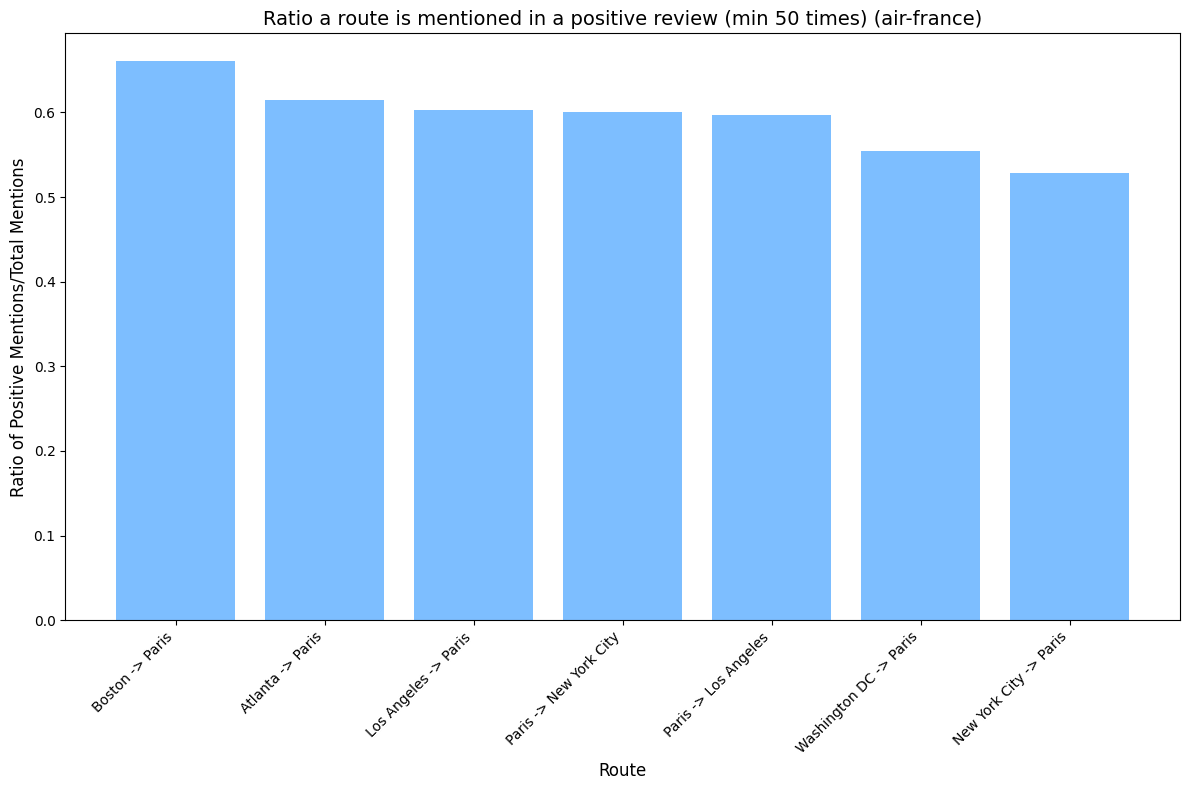

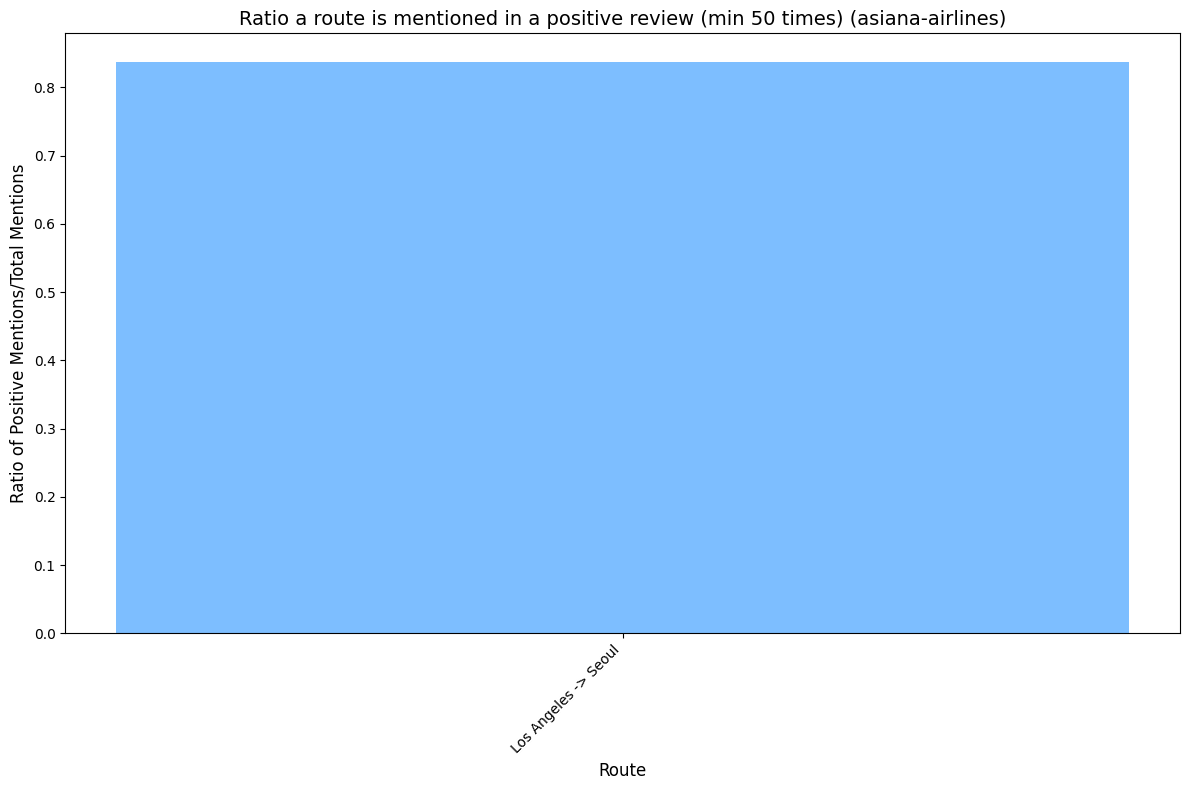

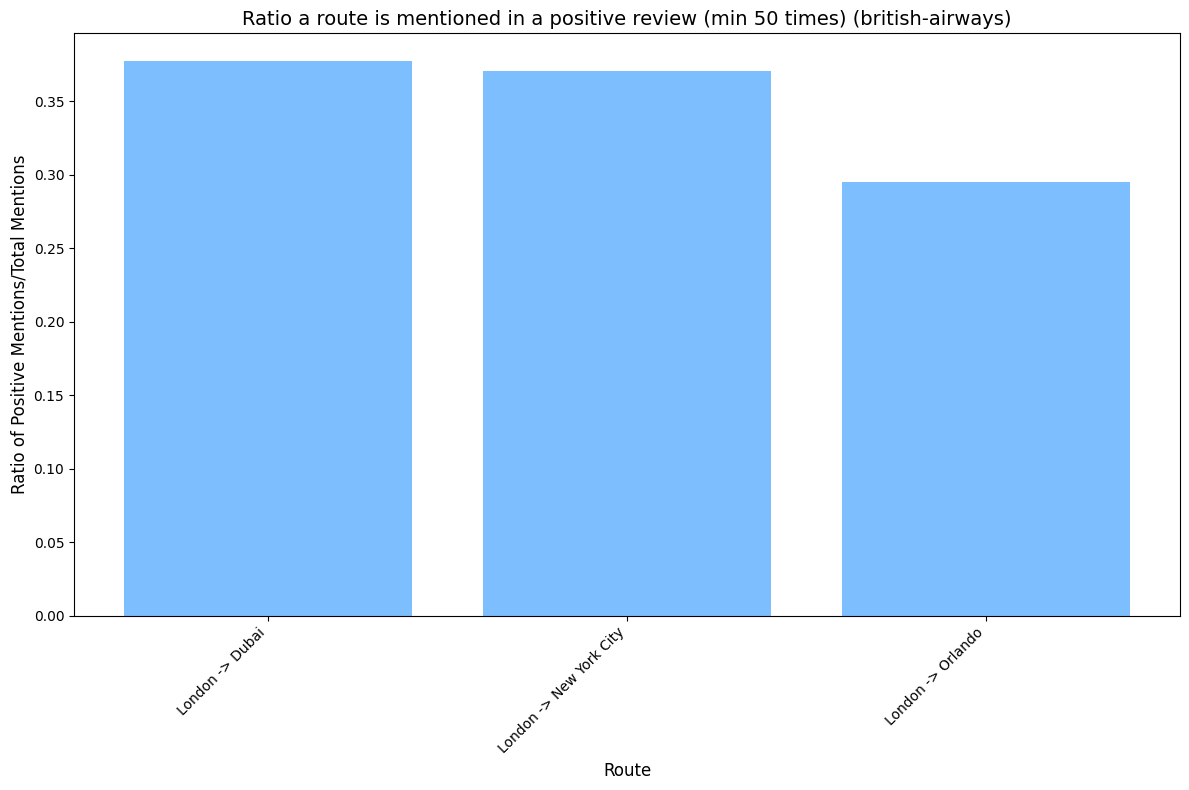

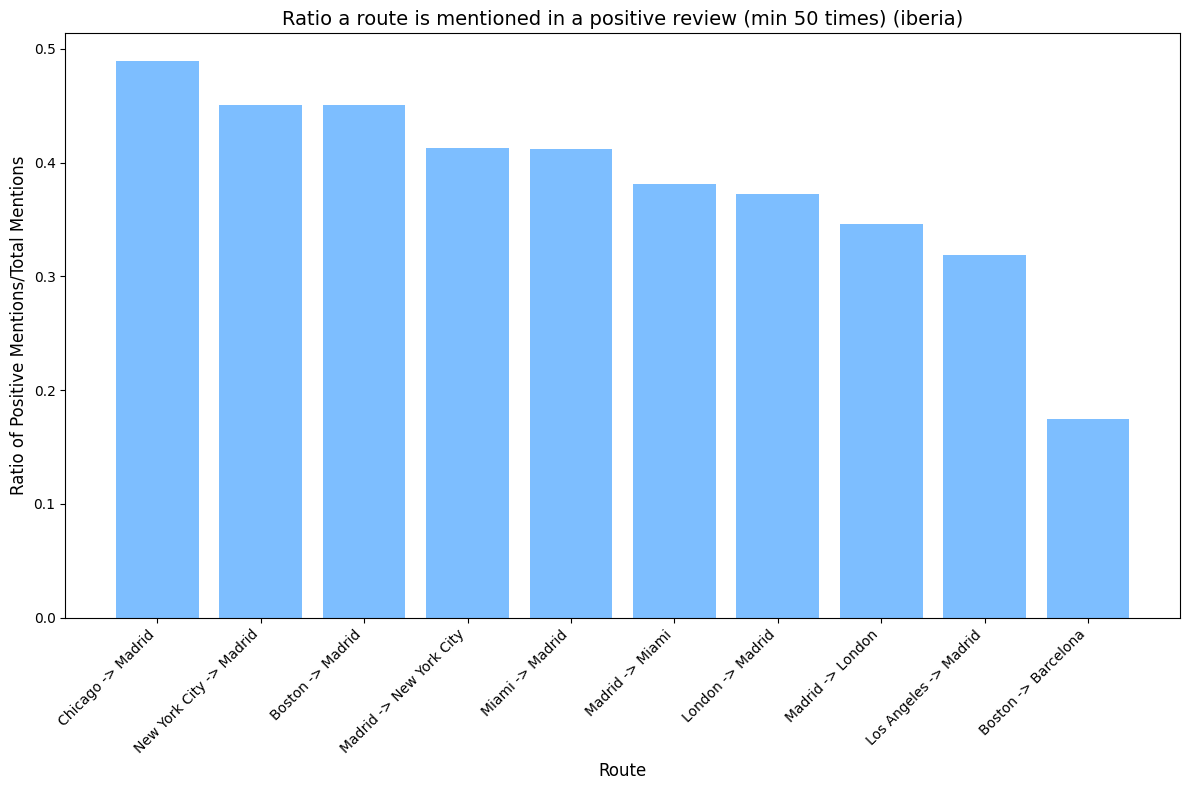

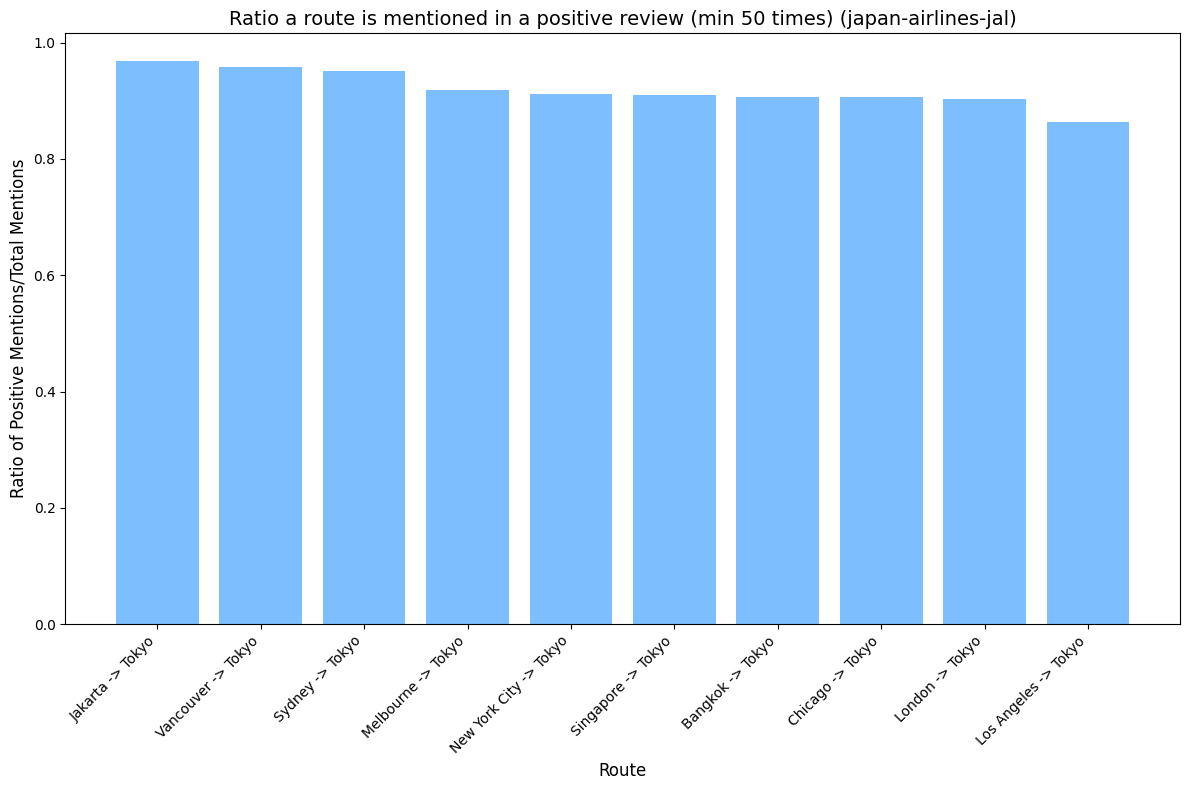

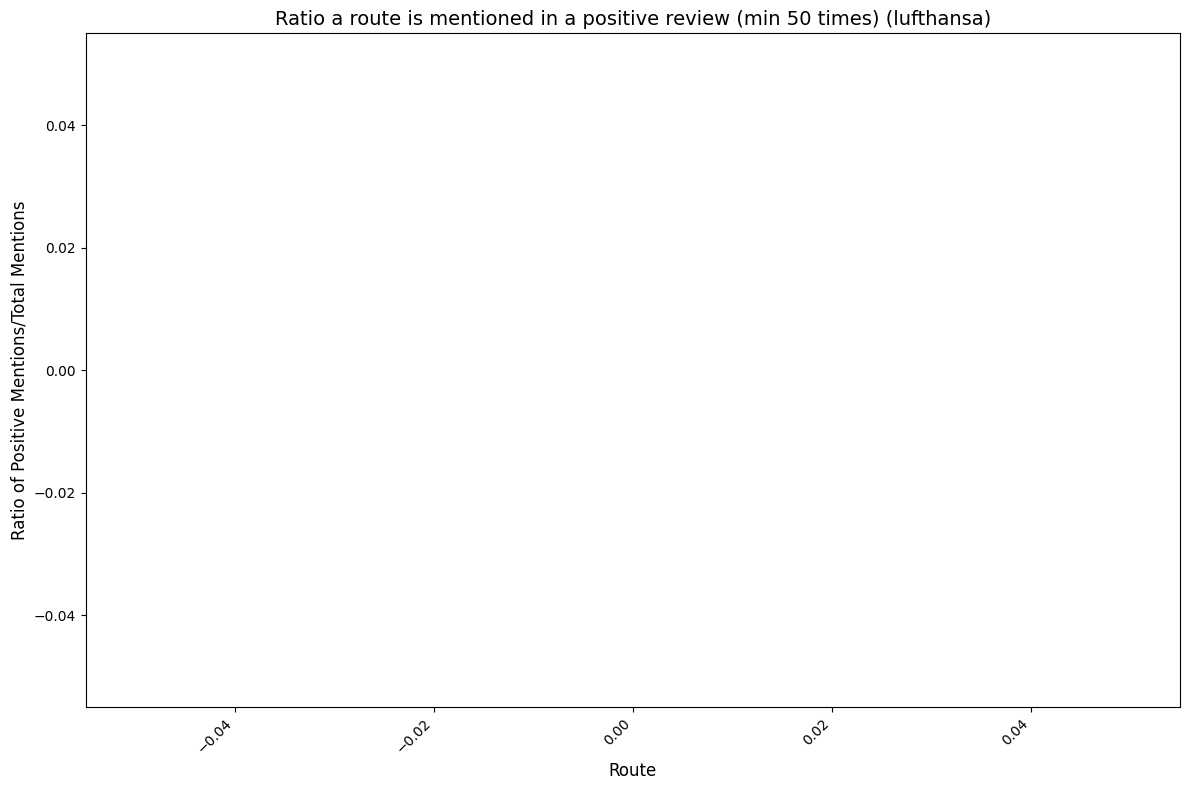

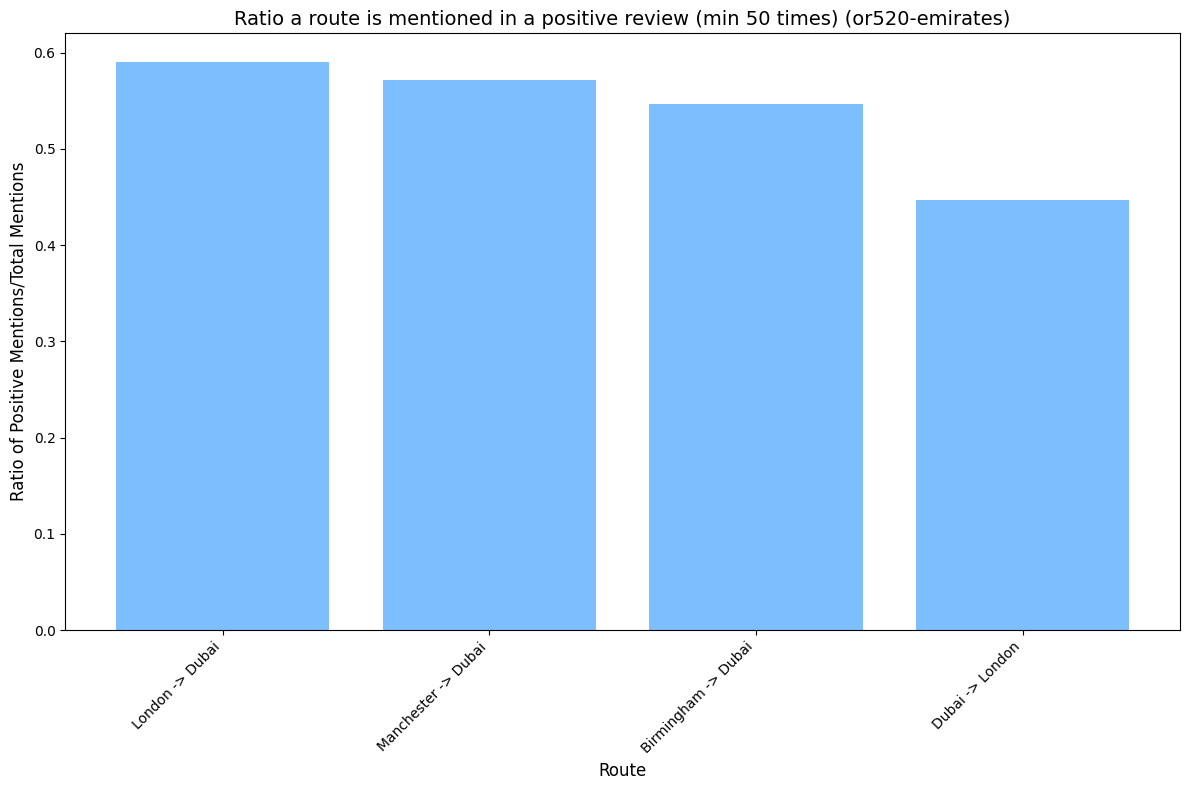

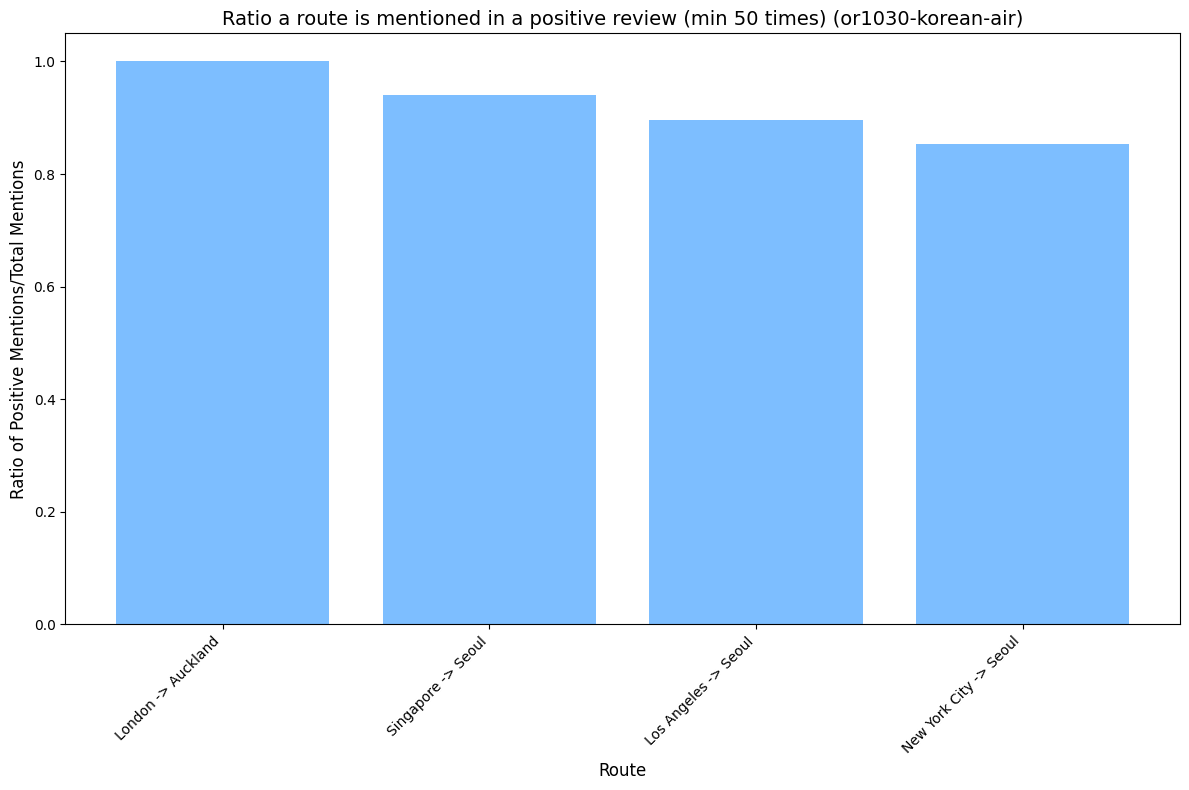

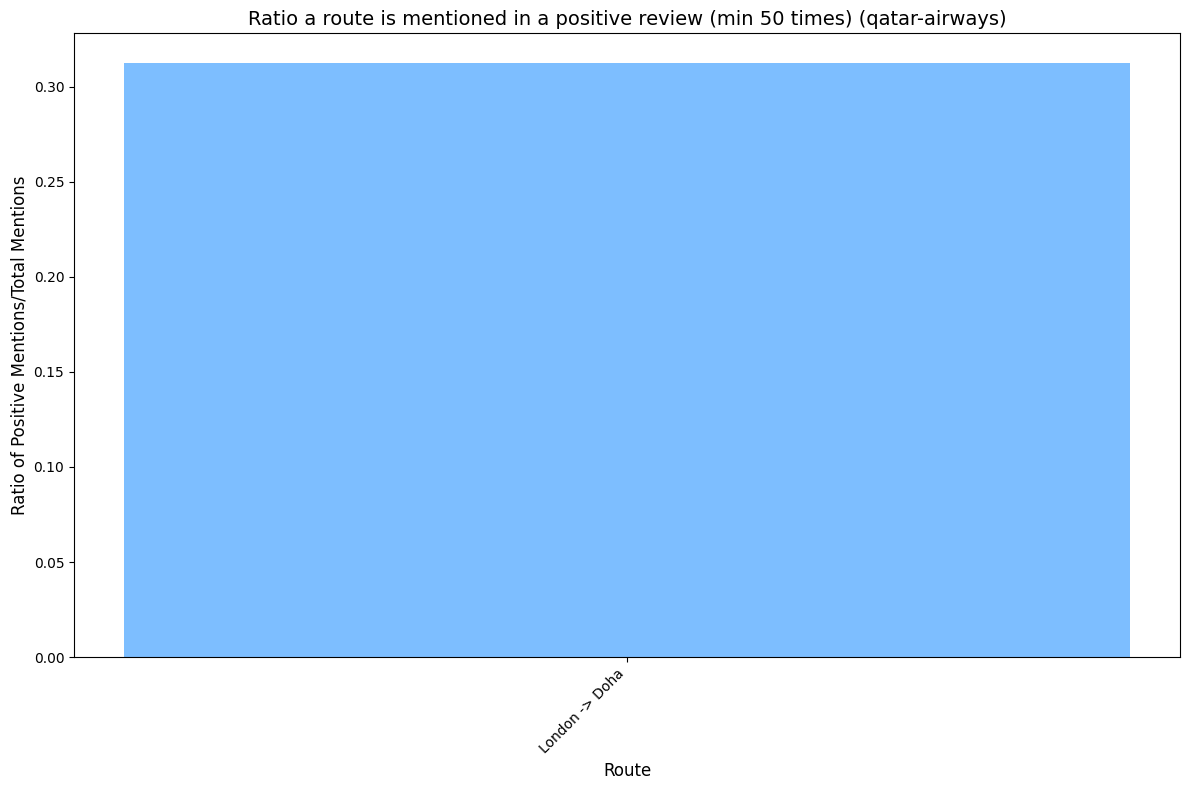

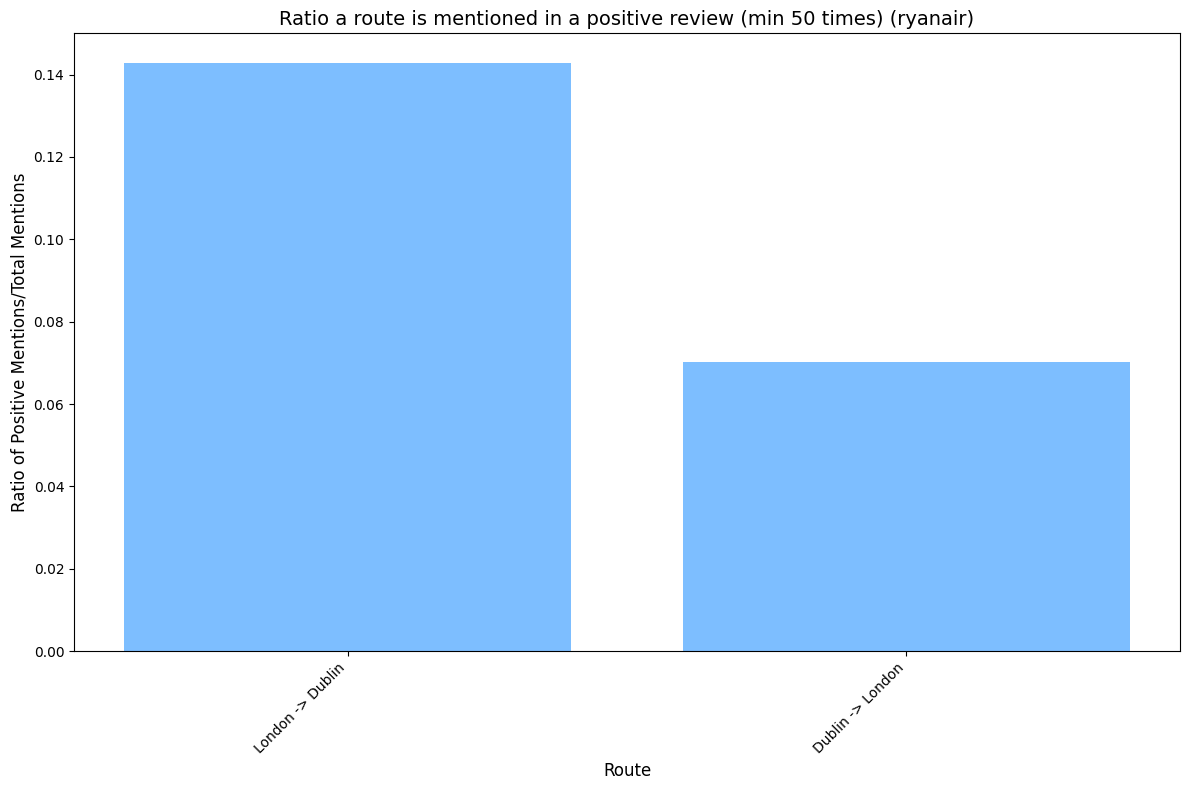

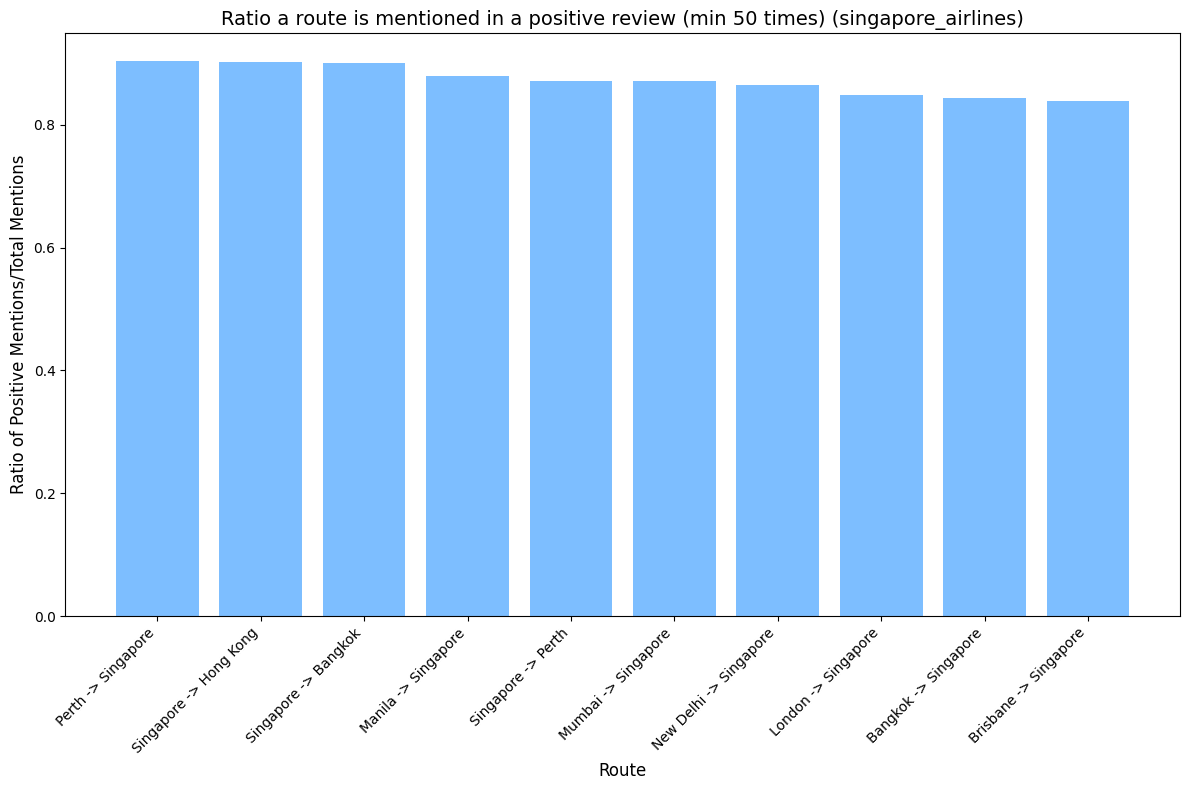

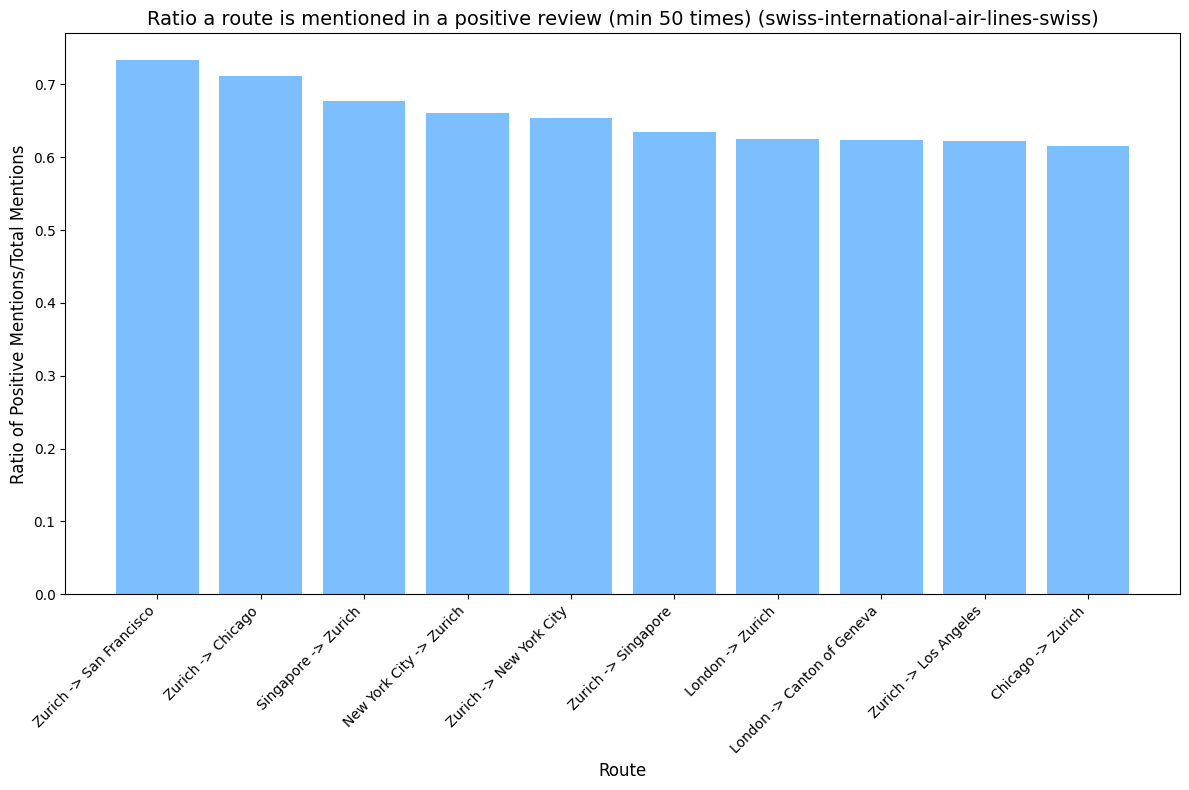

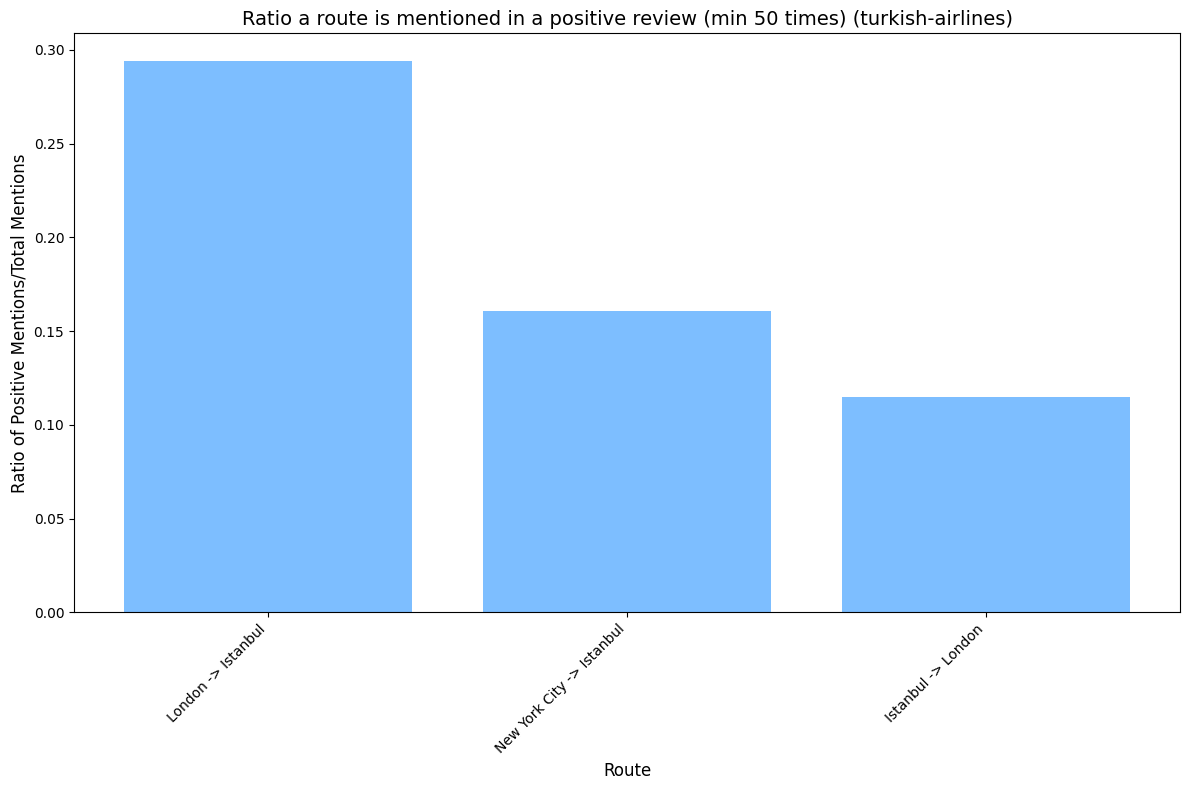

In [34]:
for company in companies:
    company_name = company
    good_travels(data, company_name)

In [40]:
def interactive_bigram_wordcloud(data, min_bigrams=2):
    # Get unique options for user selection
    companies = sorted(data['company'].unique())

    # User selects the company
    print("Available Companies:")
    for i, company in enumerate(companies, 1):
        print(f"{i}. {company}")
    company_choice = int(input("Select a company (enter the number): "))
    company_name = companies[company_choice - 1]

    # Filter data for the selected company
    company_data = data[data['company'] == company_name]

    # User specifies the travel date range
    print("\nSpecify the travel date range (YYYY-MM-DD):")
    start_date1 = input("Start date: ")
    end_date1 = input("End date: ")

    start_date = start_date1
    end_date = end_date1

    # Convert to datetime and filter the data
    company_data['travel_date'] = pd.to_datetime(company_data['travel_date'])
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)
    company_data = company_data[(company_data['travel_date'] >= start_date) & (company_data['travel_date'] <= end_date)]

    if company_data.empty:
        print("\nNo data available for the selected date range.")
        return

    # User selects the departure city
    departure_cities = sorted(company_data['departure'].unique())
    print("\nAvailable Departure Cities:")
    for i, city in enumerate(departure_cities, 1):
        print(f"{i}. {city}")
    departure_choice = int(input("Select a departure city (enter the number): "))
    departure_city = departure_cities[departure_choice - 1]

    # Filter data for the selected departure city
    departure_data = company_data[company_data['departure'] == departure_city]

    # User selects the destination city
    destination_cities = sorted(departure_data['destination'].unique())
    print("\nAvailable Destination Cities:")
    for i, city in enumerate(destination_cities, 1):
        print(f"{i}. {city}")
    destination_choice = int(input("Select a destination city (enter the number): "))
    destination_city = destination_cities[destination_choice - 1]

    # Filter data for the selected destination city
    route_data = departure_data[departure_data['destination'] == destination_city]

    # Calculate the number of comments and average satisfaction ratio
    total_comments = len(route_data)
    if total_comments > 0:
        avg_satisfaction = route_data['rating'].mean()
    else:
        avg_satisfaction = 0

    print(f"\nNumber of Comments: {total_comments}")
    print(f"Average Satisfaction Ratio: {avg_satisfaction:.2f}")

    route_data['cleaned_review_text'] = route_data['review_text'].dropna().apply(preprocess_text)

    # Extract bigrams
    all_text = ' '.join(route_data['cleaned_review_text'].dropna())
    bigram_list = list(bigrams(all_text.split()))
    bigram_counts = Counter(bigram_list)

    # Filter bigrams appearing more than `min_bigrams` times
    frequent_bigrams = {f"{w1} {w2}": count for (w1, w2), count in bigram_counts.items() if count > min_bigrams}

    # Calculate average ratings for each bigram and count occurrences
    def bigram_rating(bigram):
        pattern = r'\b{}\b \b{}\b'.format(bigram[0], bigram[1])
        reviews_containing_bigram = route_data[route_data['cleaned_review_text'].str.contains(pattern, na=False, regex=True)]
        return reviews_containing_bigram['rating'].mean(), len(reviews_containing_bigram)

    bigram_ratings = {bigram: bigram_rating(tuple(bigram.split())) for bigram in frequent_bigrams.keys()}

    # Define min/max rating
    min_rating = 1
    max_rating = 5

    # Define color scale logic
    def color_func(word, font_size, position, orientation, random_state=None, **kwargs):
        rating, _ = bigram_ratings[word]

        # Color according to the rating
        if rating <= 1.5:  # Dark red
            color = sns.color_palette("Reds", 7)[6]
        elif rating <= 2.2:  # Red
            color = sns.color_palette("Reds", 7)[4]
        elif rating <= 2.8:  # Grey
            color = sns.color_palette("Greys", 7)[4]
        elif rating <= 3.5:  # Light green
            color = sns.color_palette("Greens", 7)[2]
        else:  # Dark green
            color = sns.color_palette("Greens", 7)[6]

        return tuple([int(c * 255) for c in color[:3]])

    # Generate word cloud
    wc = WordCloud(width=800, height=400, background_color='white', color_func=color_func).generate_from_frequencies(frequent_bigrams)

    # Display word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Bigram WordCloud for {company_name} ({departure_city} -> {destination_city}) ({start_date1} -> {end_date1})", fontsize=16)
    plt.show()

    # Print bigram ratings and frequencies
    for bigram, (rating, count) in bigram_ratings.items():
        print(f"Bigram: {bigram}, Avg. Rating: {rating:.2f}, Count: {count}")


Available Companies:
1. air-france
2. asiana-airlines
3. british-airways
4. iberia
5. japan-airlines-jal
6. lufthansa
7. or1030-korean-air
8. or520-emirates
9. qatar-airways
10. ryanair
11. singapore_airlines
12. swiss-international-air-lines-swiss
13. turkish-airlines
Select a company (enter the number): 13

Specify the travel date range (YYYY-MM-DD):
Start date: 2022-01-01
End date: 2024-12-15


<ipython-input-40-15b5d5b25ea2>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  company_data['travel_date'] = pd.to_datetime(company_data['travel_date'])



Available Departure Cities:
1. Abidjan
2. Abu Dhabi
3. Abuja
4. Accra
5. Adana
6. Addis Ababa
7. Adelaide
8. Aktau
9. Alanya
10. Albuquerque
11. Alexandria
12. Algiers
13. Almaty
14. Amman
15. Amsterdam
16. Ankara
17. Antalya
18. Astana
19. Athens
20. Atlanta
21. Auckland
22. Austin
23. Baghdad
24. Bahrain
25. Baku
26. Balikpapan
27. Balochistan Province
28. Baltimore
29. Bamako
30. Bangkok
31. Banjul
32. Barcelona
33. Bari
34. Basel
35. Batumi
36. Beijing
37. Beirut
38. Belgrade
39. Berlin
40. Bilbao
41. Billund
42. Birmingham
43. Bishkek
44. Bodrum District
45. Bogota
46. Bologna
47. Bonn
48. Bordeaux
49. Boston
50. Brussels
51. Bucharest
52. Budapest
53. Buenos Aires
54. Cairo
55. Calgary
56. Cali
57. Cancun
58. Canton of Geneva
59. Cape Town Central
60. Caracas
61. Casablanca
62. Catania
63. Cebu Island
64. Chicago
65. Chisinau
66. Chitose
67. Cluj-Napoca
68. Colombo
69. Conakry
70. Copenhagen
71. Cork
72. Cotonou
73. Da Nang
74. Dakar
75. Dalaman
76. Dallas
77. Dammam
78. Dar es 

<ipython-input-40-15b5d5b25ea2>:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  route_data['cleaned_review_text'] = route_data['review_text'].dropna().apply(preprocess_text)


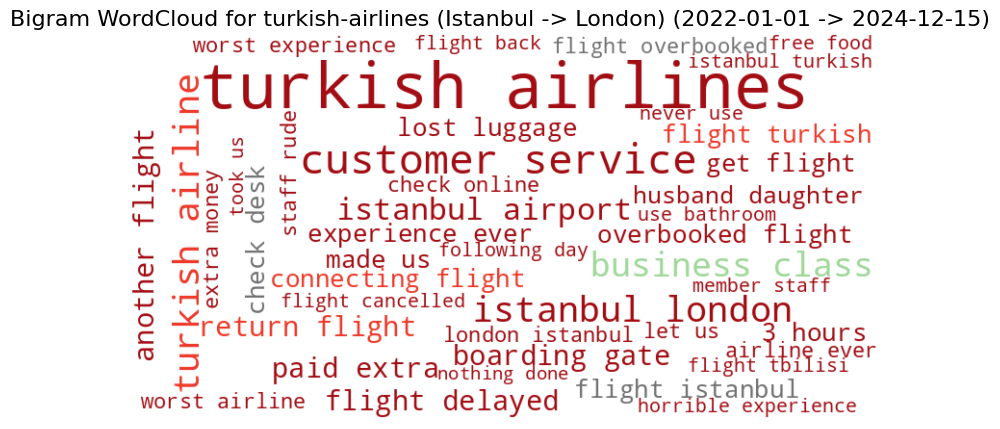

Bigram: customer service, Avg. Rating: 1.00, Count: 10
Bigram: worst experience, Avg. Rating: 1.00, Count: 3
Bigram: experience ever, Avg. Rating: 1.00, Count: 4
Bigram: turkish airlines, Avg. Rating: 1.45, Count: 22
Bigram: flight overbooked, Avg. Rating: 2.33, Count: 3
Bigram: paid extra, Avg. Rating: 1.00, Count: 4
Bigram: extra money, Avg. Rating: 1.00, Count: 2
Bigram: staff rude, Avg. Rating: 1.00, Count: 3
Bigram: return flight, Avg. Rating: 2.00, Count: 5
Bigram: let us, Avg. Rating: 1.00, Count: 3
Bigram: check online, Avg. Rating: 1.00, Count: 2
Bigram: check desk, Avg. Rating: 2.33, Count: 3
Bigram: 3 hours, Avg. Rating: 1.00, Count: 3
Bigram: get flight, Avg. Rating: 1.00, Count: 3
Bigram: made us, Avg. Rating: 1.00, Count: 4
Bigram: lost luggage, Avg. Rating: 1.25, Count: 4
Bigram: istanbul airport, Avg. Rating: 1.00, Count: 5
Bigram: airline ever, Avg. Rating: 1.00, Count: 3
Bigram: overbooked flight, Avg. Rating: 1.00, Count: 4
Bigram: boarding gate, Avg. Rating: 1.00, C

In [41]:
interactive_bigram_wordcloud(data, 2)